# ML Final Project: Credit Card Default Prediction

**Course:** CS677 - Machine Learning (Fall 2025)

**Team Members:** Fnu Ashutosh (U01955320), Atharva Pande (U01985210), Kenji Okura (U01769019) 

# 1. Introduction and Problem Statement

## 1.1 Business Context

Credit card default prediction is a critical risk management challenge for financial institutions. In 2024, consumer credit card debt in the United States exceeded $1.08 trillion, with default rates averaging 3-4% annually. Each defaulted account represents significant financial loss:

- **Average loss per default**: $10,000+ (principal + interest + collection costs)
- **Total industry impact**: $30-40 billion annually
- **Opportunity cost**: Rejecting creditworthy customers costs ~$200 per applicant in lost revenue

Financial institutions face a fundamental trade-off:
- **Too conservative**: Reject good customers, lose revenue, limit market share
- **Too aggressive**: Approve risky customers, incur default losses

## 1.2 Problem Statement

**Primary Objective:** Develop a machine learning model to predict credit card default with optimal balance between:
1. **Recall (Sensitivity)**: Catching actual defaulters before they default
2. **Specificity**: Approving creditworthy customers to maximize revenue

**Research Questions:**
1. What is the theoretical performance ceiling with available features?
2. Which ML algorithms perform best for this imbalanced classification task?
3. How do different cost-sensitive learning approaches compare?
4. What are the most important predictive features?
5. What additional data would be needed to exceed current performance limits?

## 1.3 Dataset Selection and Justification

**Dataset:** UCI Machine Learning Repository - Default of Credit Card Clients Dataset  
**Source:** Yeh, I. C., & Lien, C. H. (2009)  
**Size:** 30,000 credit card clients  

### Why This Dataset?

1. **Real-world relevance**: Actual banking data from a major Taiwanese financial institution
2. **Sufficient size**: 30,000 samples provide statistical power for ML models
3. **Rich feature set**: 23 features covering demographics, payment history, and credit utilization
4. **Class imbalance**: 22.12% default rate reflects real-world distribution
5. **Research benchmark**: Widely cited dataset (1,000+ papers) enabling comparison
6. **Educational value**: Demonstrates concepts from entire CS677 curriculum

### Dataset Features (23 Total):

**Demographics (4 features):**
- LIMIT_BAL: Credit limit (NT dollars)
- SEX: Gender (1=male, 2=female)
- EDUCATION: Education level (1=graduate, 2=university, 3=high school, 4=others)
- MARRIAGE: Marital status (1=married, 2=single, 3=others)
- AGE: Age in years

**Payment Status (6 features):** PAY_0 to PAY_6  
Repayment status from September (0) to April (6):
- -1 = pay duly
- 1 = payment delay for 1 month
- 2 = payment delay for 2 months
- ...
- 9 = payment delay for 9+ months

**Bill Amount (6 features):** BILL_AMT1 to BILL_AMT6  
Bill statement amount from September (1) to April (6)

**Payment Amount (6 features):** PAY_AMT1 to PAY_AMT6  
Previous payment amount from September (1) to April (6)

**Target Variable:**
- default.payment.next.month: 1 = default, 0 = no default

# 2. Section 1: Exploratory Data Analysis (EDA) <a id='2-section-1-eda'></a>
**Responsible Member:** Fnu Ashutosh (U01955320)
- Data loading and initial inspection
- Statistical summaries and distributions
- Missing values and data quality assessment
- Outlier detection and treatment strategy
- Correlation analysis and feature relationships
- Class distribution and imbalance analysi

In [2]:
# Import required libraries
# Standard data manipulation and analysis
import pandas as pd
import numpy as np
from scipy import stats

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Machine learning libraries
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report, roc_curve, auc
)

# XGBoost for gradient boosting
from xgboost import XGBClassifier

# Imbalanced learning
from imblearn.over_sampling import SMOTE

# UCI ML Repository access
from ucimlrepo import fetch_ucirepo

# Configuration
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: f'{x:.4f}')

# Set random seed for reproducibility across all experiments
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

## 2.1 Data Loading and Initial Inspection

In [3]:
credit_card = fetch_ucirepo(id=350)

# Extract features and target
X = credit_card.data.features
y = credit_card.data.targets.values.ravel()

In [4]:
# Rename columns for clarity
X.columns = [
    'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE',
    'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
    'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
    'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'
]


In [6]:
print(f"Number of samples: {len(X):,}")
print(f"Number of features: {len(X.columns)}")
print(f"Target variable shape: {y.shape}")
print(f"Target variable type: {y.dtype}")
# print("Feature names:")
# for i, col in enumerate(X.columns, 1):
#     print(f"  {i:2d}. {col}")

Number of samples: 30,000
Number of features: 23
Target variable shape: (30000,)
Target variable type: int64


In [7]:
print(X.columns, 1)

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'],
      dtype='object') 1


---

### Dataset Variables Information

Below is the complete mapping of variables in the UCI Credit Card Default dataset:

| Variable Name | Role | Type | Category | Description | Missing Values |
|---------------|------|------|----------|-------------|----------------|
| ID | ID | Integer | - | Customer ID | No |
| X1 / LIMIT_BAL | Feature | Integer | Financial | Credit Limit Amount | No |
| X2 / SEX | Feature | Integer | Demographic | Gender (1=Male, 2=Female) | No |
| X3 / EDUCATION | Feature | Integer | Demographic | Education Level (1=Graduate, 2=University, 3=High School, 4=Others) | No |
| X4 / MARRIAGE | Feature | Integer | Demographic | Marital Status (1=Married, 2=Single, 3=Others) | No |
| X5 / AGE | Feature | Integer | Demographic | Age in Years | No |
| X6 / PAY_0 | Feature | Integer | Payment History | Repayment Status (September) | No |
| X7 / PAY_2 | Feature | Integer | Payment History | Repayment Status (August) | No |
| X8 / PAY_3 | Feature | Integer | Payment History | Repayment Status (July) | No |
| X9 / PAY_4 | Feature | Integer | Payment History | Repayment Status (June) | No |
| X10 / PAY_5 | Feature | Integer | Payment History | Repayment Status (May) | No |
| X11 / PAY_6 | Feature | Integer | Payment History | Repayment Status (April) | No |
| X12 / BILL_AMT1 | Feature | Integer | Billing | Bill Statement Amount (September) | No |
| X13 / BILL_AMT2 | Feature | Integer | Billing | Bill Statement Amount (August) | No |
| X14 / BILL_AMT3 | Feature | Integer | Billing | Bill Statement Amount (July) | No |
| X15 / BILL_AMT4 | Feature | Integer | Billing | Bill Statement Amount (June) | No |
| X16 / BILL_AMT5 | Feature | Integer | Billing | Bill Statement Amount (May) | No |
| X17 / BILL_AMT6 | Feature | Integer | Billing | Bill Statement Amount (April) | No |
| X18 / PAY_AMT1 | Feature | Integer | Payment | Payment Amount (September) | No |
| X19 / PAY_AMT2 | Feature | Integer | Payment | Payment Amount (August) | No |
| X20 / PAY_AMT3 | Feature | Integer | Payment | Payment Amount (July) | No |
| X21 / PAY_AMT4 | Feature | Integer | Payment | Payment Amount (June) | No |
| X22 / PAY_AMT5 | Feature | Integer | Payment | Payment Amount (May) | No |
| X23 / PAY_AMT6 | Feature | Integer | Payment | Payment Amount (April) | No |
| Y / default.payment.next.month | Target | Binary | - | Default Payment (1=Yes, 0=No) | No |

**Note:** Repayment status scale: -1=Pay duly, 1=Payment delay for 1 month, 2=Payment delay for 2 months, etc.

In [ ]:
# Create comprehensive feature name mapping for better readability
# Mapping from X1, X2... column names to meaningful names
FEATURE_NAME_MAPPING = {
  "LIMIT_BAL": "Credit Limit Amount",
  "SEX": "Gender",
  "EDUCATION": "Education Level",
  "MARRIAGE": "Marital Status",
  "AGE": "Age",
  "PAY_0": "Repayment Status (Sep)",
  "PAY_2": "Repayment Status (Aug)",
  "PAY_3": "Repayment Status (Jul)",
  "PAY_4": "Repayment Status (Jun)",
  "PAY_5": "Repayment Status (May)",
  "PAY_6": "Repayment Status (Apr)",
  "BILL_AMT1": "Bill Amount (Sep)",
  "BILL_AMT2": "Bill Amount (Aug)",
  "BILL_AMT3": "Bill Amount (Jul)",
  "BILL_AMT4": "Bill Amount (Jun)",
  "BILL_AMT5": "Bill Amount (May)",
  "BILL_AMT6": "Bill Amount (Apr)",
  "PAY_AMT1": "Payment Amount (Sep)",
  "PAY_AMT2": "Payment Amount (Aug)",
  "PAY_AMT3": "Payment Amount (Jul)",
  "PAY_AMT4": "Payment Amount (Jun)",
  "PAY_AMT5": "Payment Amount (May)",
  "PAY_AMT6": "Payment Amount (Apr)"
}

## 2.2 Dataset Structure and Basic Information

**Key Questions:**
- What is the shape and size of our dataset?
- What data types are present?
- Is the data loaded correctly?

- DATASET DIMENSIONS

In [8]:
print(f"Total samples: {X.shape[0]:,}")
print(f"Total features: {X.shape[1]}")
print(f"Total data points: {X.shape[0] * X.shape[1]:,}")

Total samples: 30,000
Total features: 23
Total data points: 690,000


- FIRST 5 SAMPLES

In [9]:
display(X.head())

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0
1,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000
2,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000
3,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000
4,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679


- TARGET VARIABLE (First 10 values)

In [ ]:
print(y[:10])

- DATA TYPES AND MEMORY USAGE

In [ ]:
# Data types and memory usage
print(X.info())
print(f" Memory usage: {X.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

## 2.3 Statistical Summary

**Objective:** Understand the central tendency, spread, and range of each feature.

Statistical measures reveal:
- **Scale differences**: Some features are in thousands (LIMIT_BAL, BILL_AMT) vs. categorical (SEX, EDUCATION)
- **Potential outliers**: Large gaps between 75th percentile and max values
- **Data quality issues**: Unexpected values in categorical features

- DESCRIPTIVE STATISTICS

In [10]:
# Comprehensive statistical summary
stats_summary = X.describe()
display(stats_summary)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
count,30000.0000,30000.0000,30000.0000,30000.0000,30000.0000,30000.0000,30000.0000,30000.0000,30000.0000,30000.0000,30000.0000,30000.0000,30000.0000,30000.0000,30000.0000,30000.0000,30000.0000,30000.0000,30000.0000,30000.0000,30000.0000,30000.0000,30000.0000
mean,167484.3227,1.6037,1.8531,1.5519,35.4855,-0.0167,-0.1338,-0.1662,-0.2207,-0.2662,-0.2911,51223.3309,49179.0752,47013.1548,43262.9490,40311.4010,38871.7604,5663.5805,5921.1635,5225.6815,4826.0769,4799.3876,5215.5026
std,129747.6616,0.4891,0.7903,0.5220,9.2179,1.1238,1.1972,1.1969,1.1691,1.1332,1.1500,73635.8606,71173.7688,69349.3874,64332.8561,60797.1558,59554.1075,16563.2804,23040.8704,17606.9615,15666.1597,15278.3057,17777.4658
min,10000.0000,1.0000,0.0000,0.0000,21.0000,-2.0000,-2.0000,-2.0000,-2.0000,-2.0000,-2.0000,-165580.0000,-69777.0000,-157264.0000,-170000.0000,-81334.0000,-339603.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,50000.0000,1.0000,1.0000,1.0000,28.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,3558.7500,2984.7500,2666.2500,2326.7500,1763.0000,1256.0000,1000.0000,833.0000,390.0000,296.0000,252.5000,117.7500
50%,140000.0000,2.0000,2.0000,2.0000,34.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,22381.5000,21200.0000,20088.5000,19052.0000,18104.5000,17071.0000,2100.0000,2009.0000,1800.0000,1500.0000,1500.0000,1500.0000
75%,240000.0000,2.0000,2.0000,2.0000,41.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,67091.0000,64006.2500,60164.7500,54506.0000,50190.5000,49198.2500,5006.0000,5000.0000,4505.0000,4013.2500,4031.5000,4000.0000
max,1000000.0000,2.0000,6.0000,3.0000,79.0000,8.0000,8.0000,8.0000,8.0000,8.0000,8.0000,964511.0000,983931.0000,1664089.0000,891586.0000,927171.0000,961664.0000,873552.0000,1684259.0000,896040.0000,621000.0000,426529.0000,528666.0000


- Key Observations

In [11]:
print(f"  • Credit Limit Range: NT${X['LIMIT_BAL'].min():,.0f} - NT${X['LIMIT_BAL'].max():,.0f}")
print(f"  • Average Credit Limit: NT${X['LIMIT_BAL'].mean():,.0f}")
print(f"  • Age Range: {X['AGE'].min():.0f} - {X['AGE'].max():.0f} years")
print(f"  • Average Age: {X['AGE'].mean():.1f} years")

  • Credit Limit Range: NT$10,000 - NT$1,000,000
  • Average Credit Limit: NT$167,484
  • Age Range: 21 - 79 years
  • Average Age: 35.5 years


## 2.4 Missing Values Analysis & Duplicate

**Data Quality Check:** Missing values can bias models or cause errors. 

To check:
1. Count of missing values per feature
2. Percentage of missingness
3. Patterns in missing data (MCAR, MAR, or MNAR)

- MISSING VALUES ANALYSIS

In [12]:
# Check for missing values
missing_count = X.isnull().sum()
missing_percent = (X.isnull().sum() / len(X)) * 100

missing_df = pd.DataFrame({
    'Feature': X.columns,
    'Missing_Count': missing_count.values,
    'Missing_Percent': missing_percent.values
})

missing_df = missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)

if len(missing_df) > 0:
    display(missing_df)
else:
    print("NO MISSING VALUES DETECTED")
    

NO MISSING VALUES DETECTED


Observation
- All 30,000 samples have complete data across all 23 features.
- This is excellent for model training - no imputation needed.

## Duplicate check utility

In [13]:
# Duplicate check utility
def check_duplicates(X_df, y=None, show_n=10):
    dup_any = X_df.duplicated(keep=False)
    dup_count_any = int(dup_any.sum())
    if dup_count_any:
        display(X_df[dup_any].head(show_n))
    dup_excl_first = int(X_df.duplicated(keep='first').sum())

    dup_with_target_count = None
    if y is not None:
        df = X_df.copy()
        df['default'] = y
        dup_tgt_any = df.duplicated(keep=False)
        dup_with_target_count = int(dup_tgt_any.sum())
        if dup_with_target_count:
            display(df[dup_tgt_any].head(show_n))
        dup_tgt_excl_first = int(df.duplicated(keep='first').sum())

    return {
        'dup_feature_any': dup_count_any,
        'dup_feature_excl_first': dup_excl_first,
        'dup_with_target_any': dup_with_target_count
    }

# Run duplicate checks on main dataset
dup_stats = check_duplicates(X, y)
print("\nResult:", len(dup_stats))

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
18,360000,2,1,1,49,1,-2,-2,-2,-2,-2,0,0,0,0,0,0,0,0,0,0,0,0
291,50000,2,2,2,22,1,-2,-2,-2,-2,-2,0,0,0,0,0,0,0,0,0,0,0,0
627,230000,1,1,1,39,-1,-1,-1,-1,-1,-1,660,660,660,660,660,660,660,660,660,660,660,660
839,500000,1,1,1,43,1,-2,-2,-2,-2,-2,0,0,0,0,0,0,0,0,0,0,0,0
881,210000,2,2,1,49,1,-2,-2,-2,-2,-2,0,0,0,0,0,0,0,0,0,0,0,0
1093,360000,1,2,1,41,1,-2,-2,-2,-2,-2,0,0,0,0,0,0,0,0,0,0,0,0
1211,160000,2,3,2,26,-1,-1,-1,-1,-1,-1,390,390,390,390,390,390,390,390,390,390,390,390
1601,150000,2,1,1,31,1,-2,-2,-2,-2,-2,0,0,0,0,0,0,0,0,0,0,0,0
1759,50000,1,2,2,26,1,-2,-2,-2,-2,-2,0,0,0,0,0,0,0,0,0,0,0,0
1964,150000,2,1,1,38,1,-2,-2,-2,-2,-2,0,0,0,0,0,0,0,0,0,0,0,0


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
18,360000,2,1,1,49,1,-2,-2,-2,-2,-2,0,0,0,0,0,0,0,0,0,0,0,0,0
627,230000,1,1,1,39,-1,-1,-1,-1,-1,-1,660,660,660,660,660,660,660,660,660,660,660,660,0
839,500000,1,1,1,43,1,-2,-2,-2,-2,-2,0,0,0,0,0,0,0,0,0,0,0,0,1
1093,360000,1,2,1,41,1,-2,-2,-2,-2,-2,0,0,0,0,0,0,0,0,0,0,0,0,1
1211,160000,2,3,2,26,-1,-1,-1,-1,-1,-1,390,390,390,390,390,390,390,390,390,390,390,390,0
1601,150000,2,1,1,31,1,-2,-2,-2,-2,-2,0,0,0,0,0,0,0,0,0,0,0,0,0
1759,50000,1,2,2,26,1,-2,-2,-2,-2,-2,0,0,0,0,0,0,0,0,0,0,0,0,0
1964,150000,2,1,1,38,1,-2,-2,-2,-2,-2,0,0,0,0,0,0,0,0,0,0,0,0,1
1980,150000,2,1,1,38,1,-2,-2,-2,-2,-2,0,0,0,0,0,0,0,0,0,0,0,0,1
2621,210000,2,1,2,39,1,-2,-2,-2,-2,-2,0,0,0,0,0,0,0,0,0,0,0,0,0



Result: 3


## 2.5 Target Variable Distribution (Class Balance)

**Most Critical EDA Step:** Understanding class distribution is essential for:
- Choosing appropriate evaluation metrics
- Deciding on sampling strategies (SMOTE, class weights)
- Setting realistic performance expectations

**Imbalanced datasets** (where one class dominates) require special handling.

- TARGET VARIABLE DISTRIBUTION

In [14]:
# Count and percentages
value_counts = pd.Series(y).value_counts().sort_index()
value_percent = pd.Series(y).value_counts(normalize=True).sort_index() * 100

print(f"Class 0 (No Default):  {value_counts[0]:,} samples ({value_percent[0]:.2f}%)")
print(f"Class 1 (Default):     {value_counts[1]:,} samples ({value_percent[1]:.2f}%)")

# Calculate imbalance ratio
imbalance_ratio = value_counts[0] / value_counts[1]
print(f"Imbalance Ratio: {imbalance_ratio:.2f}:1")
print(f"   → For every 1 defaulter, there are {imbalance_ratio:.1f} non-defaulters")


Class 0 (No Default):  23,364 samples (77.88%)
Class 1 (Default):     6,636 samples (22.12%)
Imbalance Ratio: 3.52:1
   → For every 1 defaulter, there are 3.5 non-defaulters


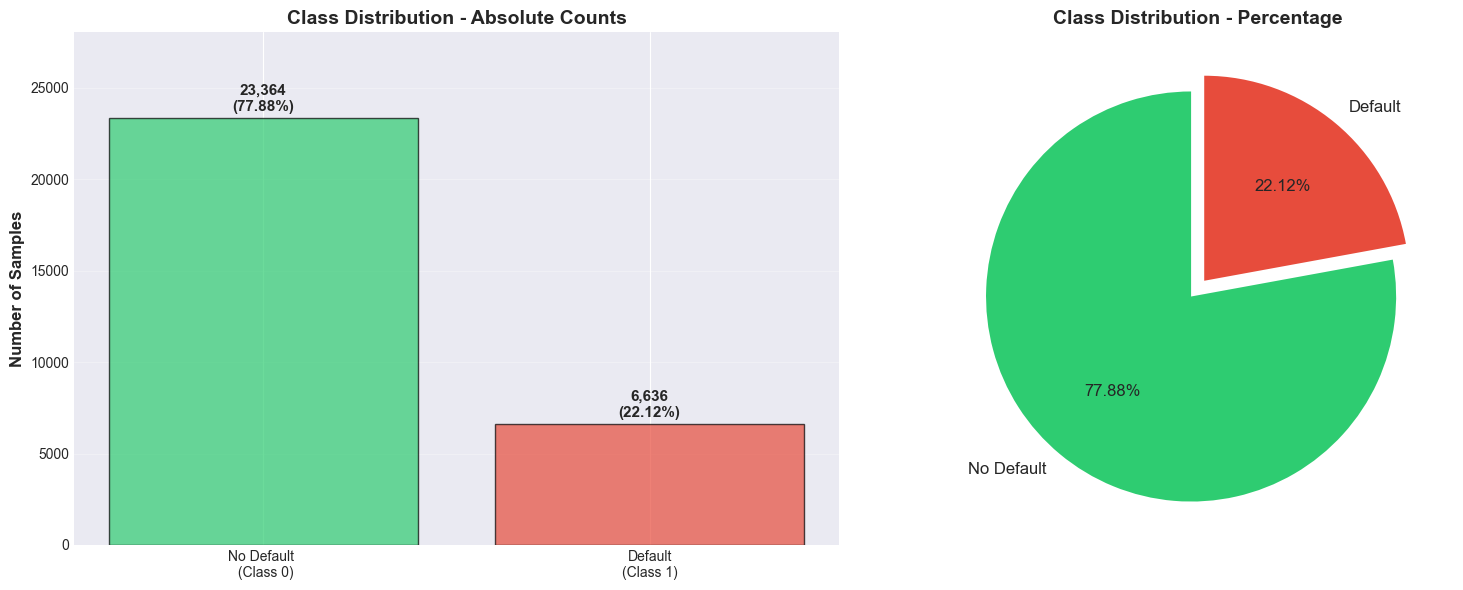

In [15]:
import matplotlib.pyplot as plt

# Visualize class distribution
# Increased figsize width slightly for better spacing
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar plot
bars = axes[0].bar(['No Default \n (Class 0)', 'Default\n(Class 1)'], value_counts.values, 
            color=['#2ecc71', '#e74c3c'], alpha=0.7, edgecolor='black')
axes[0].set_ylabel('Number of Samples', fontsize=12, fontweight='bold')
axes[0].set_title('Class Distribution - Absolute Counts', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# FIX 1: Increase the y-axis limit so text doesn't hit the top of the figure
axes[0].set_ylim(0, max(value_counts.values) * 1.2)

for i, v in enumerate(value_counts.values):
    axes[0].text(i, v + 200, f'{v:,}\n({value_percent.values[i]:.2f}%)', 
                ha='center', va='bottom', fontweight='bold', fontsize=11)

# Pie chart
colors = ['#2ecc71', '#e74c3c']
explode = (0.05, 0.05)
axes[1].pie(value_counts.values, labels=['No Default', 'Default'], autopct='%1.2f%%',
           colors=colors, explode=explode, startangle=90, textprops={'fontsize': 12})
axes[1].set_title('Class Distribution - Percentage', fontsize=14, fontweight='bold')

# FIX 2: Added wspace to prevent the pie chart labels from touching the bar chart
plt.subplots_adjust(wspace=0.3)
plt.tight_layout()
plt.show()


## 2.6 Demographic Features Analysis

**Objective:** Understand the customer demographics and their relationship to defaults.

- DEMOGRAPHIC FEATURES - VALUE COUNTS

In [5]:
# Analyze categorical demographic features
demo_features = ['SEX', 'EDUCATION', 'MARRIAGE']

for feature in demo_features:
    print(f"\n{feature}:")
    print("-" * 40)
    value_counts = X[feature].value_counts().sort_index()
    value_percent = X[feature].value_counts(normalize=True).sort_index() * 100
    
    for val in value_counts.index:
        print(f"  {val}: {value_counts[val]:,} ({value_percent[val]:.2f}%)")
        
    # Check for unexpected values
    if feature == 'SEX' and set(X[feature].unique()) != {1, 2}:
        print(f"Unexpected values detected: {X[feature].unique()}")
    elif feature == 'EDUCATION' and not set(X[feature].unique()).issubset({1, 2, 3, 4, 5, 6}):
        print(f"Unexpected values detected: {X[feature].unique()}")
    elif feature == 'MARRIAGE' and not set(X[feature].unique()).issubset({1, 2, 3}):
        print(f"Unexpected values detected: {X[feature].unique()}")


SEX:
----------------------------------------
  1: 11,888 (39.63%)
  2: 18,112 (60.37%)

EDUCATION:
----------------------------------------
  0: 14 (0.05%)
  1: 10,585 (35.28%)
  2: 14,030 (46.77%)
  3: 4,917 (16.39%)
  4: 123 (0.41%)
  5: 280 (0.93%)
  6: 51 (0.17%)
Unexpected values detected: [2 1 3 5 4 6 0]

MARRIAGE:
----------------------------------------
  0: 54 (0.18%)
  1: 13,659 (45.53%)
  2: 15,964 (53.21%)
  3: 323 (1.08%)
Unexpected values detected: [1 2 3 0]


- Visualize demographic distributions

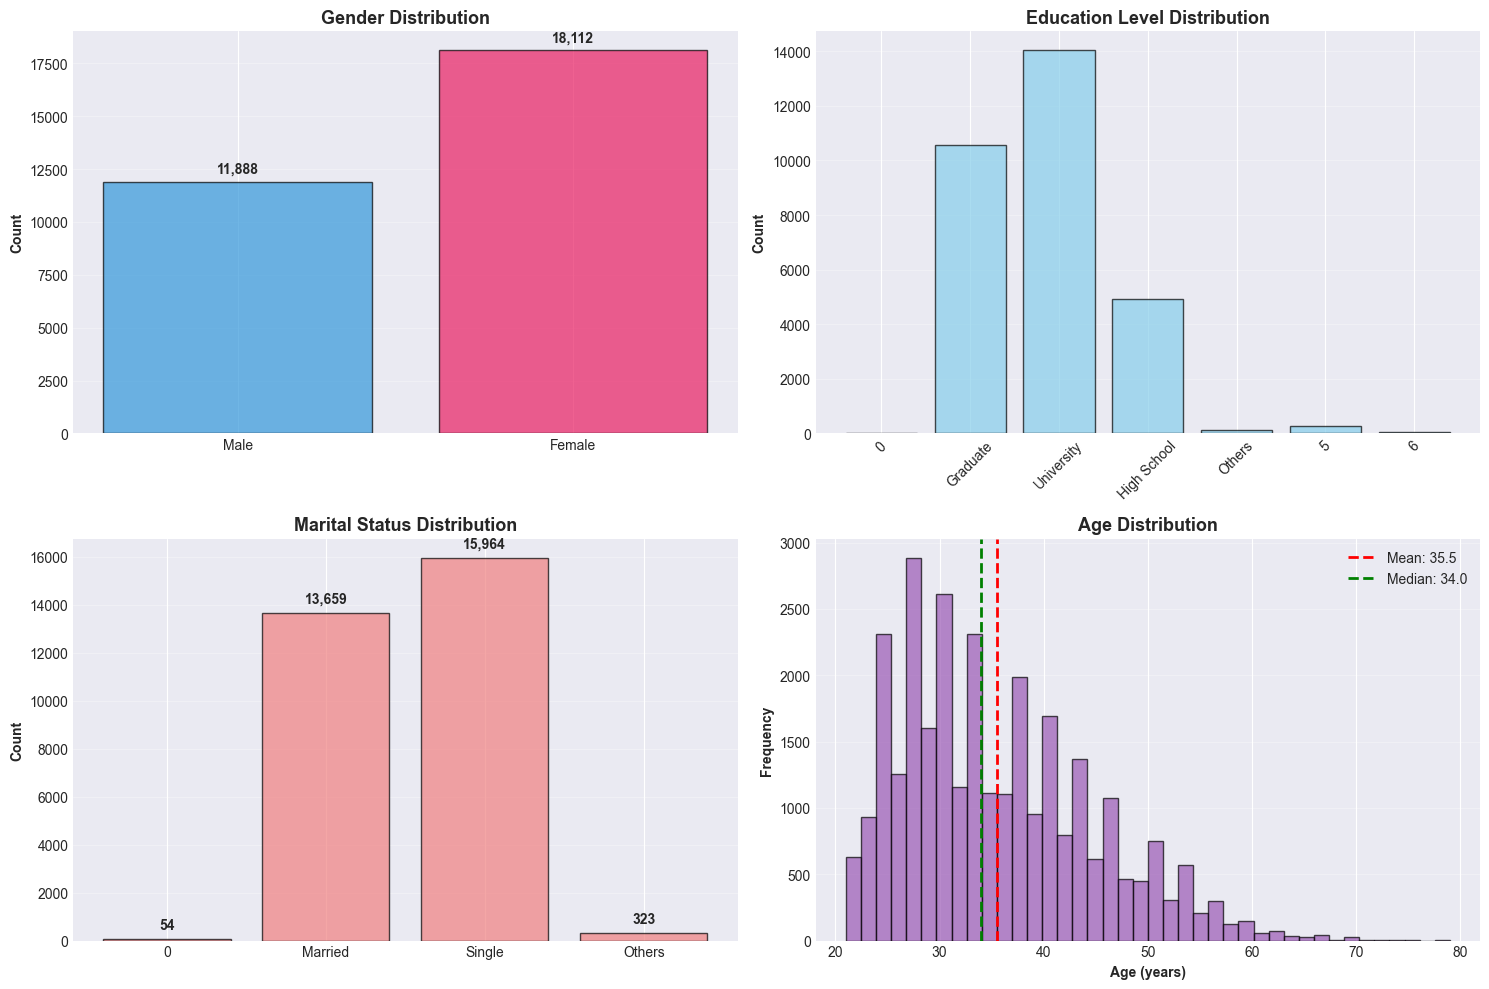

In [6]:
# Visualize demographic distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Gender distribution
sex_counts = X['SEX'].value_counts().sort_index()
axes[0, 0].bar(['Male', 'Female'], sex_counts.values, color=['#3498db', '#e91e63'], alpha=0.7, edgecolor='black')
axes[0, 0].set_title('Gender Distribution', fontsize=13, fontweight='bold')
axes[0, 0].set_ylabel('Count', fontweight='bold')
axes[0, 0].grid(axis='y', alpha=0.3)
for i, v in enumerate(sex_counts.values):
    axes[0, 0].text(i, v + 300, f'{v:,}', ha='center', va='bottom', fontweight='bold')

# Education distribution
edu_counts = X['EDUCATION'].value_counts().sort_index()
edu_labels = ['0', 'Graduate', 'University', 'High School', 'Others', '5', '6']
axes[0, 1].bar(range(len(edu_counts)), edu_counts.values, color='skyblue', alpha=0.7, edgecolor='black')
axes[0, 1].set_title('Education Level Distribution', fontsize=13, fontweight='bold')
axes[0, 1].set_ylabel('Count', fontweight='bold')
axes[0, 1].set_xticks(range(len(edu_counts)))
axes[0, 1].set_xticklabels(edu_labels[:len(edu_counts)], rotation=45)
axes[0, 1].grid(axis='y', alpha=0.3)

# Marriage distribution
mar_counts = X['MARRIAGE'].value_counts().sort_index()
mar_labels = ['0', 'Married', 'Single', 'Others']
axes[1, 0].bar(range(len(mar_counts)), mar_counts.values, color='lightcoral', alpha=0.7, edgecolor='black')
axes[1, 0].set_title('Marital Status Distribution', fontsize=13, fontweight='bold')
axes[1, 0].set_ylabel('Count', fontweight='bold')
axes[1, 0].set_xticks(range(len(mar_counts)))
axes[1, 0].set_xticklabels(mar_labels[:len(mar_counts)])
axes[1, 0].grid(axis='y', alpha=0.3)
for i, v in enumerate(mar_counts.values):
    axes[1, 0].text(i, v + 300, f'{v:,}', ha='center', va='bottom', fontweight='bold')

# Age distribution (histogram)
axes[1, 1].hist(X['AGE'], bins=40, color='#9b59b6', alpha=0.7, edgecolor='black')
axes[1, 1].axvline(X['AGE'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {X["AGE"].mean():.1f}')
axes[1, 1].axvline(X['AGE'].median(), color='green', linestyle='--', linewidth=2, label=f'Median: {X["AGE"].median():.1f}')
axes[1, 1].set_title('Age Distribution', fontsize=13, fontweight='bold')
axes[1, 1].set_xlabel('Age (years)', fontweight='bold')
axes[1, 1].set_ylabel('Frequency', fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [11]:
 # Display model comparison table (use in-memory variable if available, else load CSV)
print('[POST-TRAIN] Checking comparison_df')
try:
    display(comparison_df)
except NameError:
    import pandas as pd
    df = pd.read_csv('model_comparison_safe.csv')
    display(df)
print('[POST-TRAIN] Done')

[POST-TRAIN] Checking comparison_df


FileNotFoundError: [Errno 2] No such file or directory: 'model_comparison_safe.csv'

In [13]:
# Quick check of in-memory 'results' list
print('[CHECK RESULTS] Checking in-kernel results list')
try:
    print('len(results)=', len(results))
    import pprint
    pprint.pprint(results[:5])
except NameError:
    print('results not defined in kernel')

[CHECK RESULTS] Checking in-kernel results list
len(results)= 1
[{'AUC': 0.7076575965667866,
  'Accuracy': 0.8075,
  'Confusion': array([[4527,  146],
       [1009,  318]]),
  'F1-Score': 0.35510887772194305,
  'Model': 'LogisticRegression',
  'Precision': 0.6853448275862069,
  'Recall': 0.23963828183873398}]


In [ ]:
# Robust safe training run (n_iter=10 per model) — continues on error and saves incremental results
print('[ROBUST SAFE TRAIN] Starting')
from sklearn.model_selection import RandomizedSearchCV
import gc

models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
    'RandomForest': RandomForestClassifier(random_state=RANDOM_STATE),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=RANDOM_STATE),
    'SVC': SVC(probability=True, random_state=RANDOM_STATE)
}

param_dists = {
    'LogisticRegression': {'C': [0.01, 0.1, 1, 10]},
    'RandomForest': {'n_estimators': [100, 200, 300], 'max_depth': [3, 5, 7]},
    'XGBoost': {'n_estimators': [100, 200, 300], 'max_depth': [3, 5], 'learning_rate': [0.01, 0.05, 0.1]},
    'SVC': {'C': [0.1, 1, 10], 'kernel': ['rbf', 'poly']}
}

# Use existing train/test split/scaler
if 'X_train_scaled' not in globals():
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

if 'results' not in globals():
    results = []

for name, est in models.items():
    # Skip if we already have metrics for this model
    if any([r['Model'] == name for r in results]):
        print(f"[ROBUST SAFE TRAIN] Skipping {name}, results already present")
        continue

    print(f"[ROBUST SAFE TRAIN] {name}: search start")
    pdist = param_dists.get(name, None)
    try:
        if pdist:
            search = RandomizedSearchCV(est, param_distributions=pdist, n_iter=10, cv=3, scoring='f1', n_jobs=1, random_state=RANDOM_STATE, verbose=1)
            search.fit(X_train_scaled, y_train)
            best = search.best_estimator_
            print(f"[ROBUST SAFE TRAIN] {name} best params: {search.best_params_}")
        else:
            best = est
    except Exception as e:
        print(f"[ROBUST SAFE TRAIN] {name} search failed: {e}; using estimator defaults and continuing")
        best = est

    try:
        best.fit(X_train_scaled, y_train)
    except Exception as e:
        print(f"[ROBUST SAFE TRAIN] {name} final fit failed: {e}; skipping")
        continue

    y_pred = best.predict(X_test_scaled)
    try:
        y_prob = best.predict_proba(X_test_scaled)[:,1]
    except Exception:
        try:
            y_prob = best.decision_function(X_test_scaled)
        except Exception:
            y_prob = np.zeros_like(y_pred)

    metrics = {
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, zero_division=0),
        'Recall': recall_score(y_test, y_pred, zero_division=0),
        'F1-Score': f1_score(y_test, y_pred, zero_division=0),
        'AUC': roc_auc_score(y_test, y_prob) if len(np.unique(y_prob))>1 else 0.0,
        'Confusion': confusion_matrix(y_test, y_pred)
    }
    results.append(metrics)
    # Save incremental
    pd.DataFrame(results).to_csv('model_comparison_safe.csv', index=False)
    print(f"[ROBUST SAFE TRAIN] {name} done — saved incremental results")
    # Cleanup
    try:
        del search
    except Exception:
        pass
    gc.collect()

print('[ROBUST SAFE TRAIN] All done. Final results:')
import pandas as pd
comparison_df = pd.DataFrame(results).sort_values('F1-Score', ascending=False)
print(comparison_df[['Model','Accuracy','Precision','Recall','F1-Score','AUC']].to_string(index=False))
comparison_df.to_csv('model_comparison_safe.csv', index=False)
print('[ROBUST SAFE TRAIN] Completed and saved model_comparison_safe.csv')

[ROBUST SAFE TRAIN] Starting
[ROBUST SAFE TRAIN] Skipping LogisticRegression, results already present
[ROBUST SAFE TRAIN] RandomForest: search start
Fitting 3 folds for each of 9 candidates, totalling 27 fits
[ROBUST SAFE TRAIN] RandomForest best params: {'n_estimators': 300, 'max_depth': 7}
[ROBUST SAFE TRAIN] RandomForest done — saved incremental results
[ROBUST SAFE TRAIN] XGBoost: search start
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[ROBUST SAFE TRAIN] XGBoost best params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05}
[ROBUST SAFE TRAIN] XGBoost done — saved incremental results
[ROBUST SAFE TRAIN] SVC: search start
Fitting 3 folds for each of 6 candidates, totalling 18 fits


### Demographic Insights:
- Female customers: 18,112 (60.4%)
- Male customers: 11,888 (39.6%)
- Average age: 35.5 years
- Age range: 21 - 79 years

## 2.7 Credit Limit Analysis

**Business Significance:** Credit limit (LIMIT_BAL) is the total approved credit amount. 

Key questions:
- What is the distribution of credit limits?
- Are there any unusual patterns or outliers?
- How does credit limit relate to defaults?

- CREDIT LIMIT (LIMIT_BAL) ANALYSIS

In [ ]:
# Analyze credit limit distribution
# Calculate statistics
limit_stats = X['LIMIT_BAL'].describe()
print("Statistical Summary:")
print(f"  Mean:     NT$ {limit_stats['mean']:,.0f}")
print(f"  Median:   NT$ {limit_stats['50%']:,.0f}")
print(f"  Std Dev:  NT$ {limit_stats['std']:,.0f}")
print(f"  Min:      NT$ {limit_stats['min']:,.0f}")
print(f"  Max:      NT$ {limit_stats['max']:,.0f}")
print(f"  Range:    NT$ {limit_stats['max'] - limit_stats['min']:,.0f}")

In [ ]:
# Quartiles
print("Quartiles:")
print(f"  Q1 (25%): NT$ {limit_stats['25%']:,.0f}")
print(f"  Q2 (50%): NT$ {limit_stats['50%']:,.0f}")
print(f"  Q3 (75%): NT$ {limit_stats['75%']:,.0f}")
print(f"  IQR:      NT$ {limit_stats['75%'] - limit_stats['25%']:,.0f}")

**Visualization: Histograms to understand the distribution shape and identify skewness in numerical features.**

In [ ]:
# Visualize distributions for key numerical features
# Separate features from target
numerical_features = X.select_dtypes(include=[np.number]).columns.tolist()

fig, axes = plt.subplots(4, 3, figsize=(15, 12))
axes = axes.ravel()

for idx, col in enumerate(numerical_features[:12]):
    axes[idx].hist(X[col], bins=30, color='#3498db', edgecolor='black', alpha=0.7)
    display_name = FEATURE_NAME_MAPPING.get(col, col.replace('_', ' ').title())
    axes[idx].set_title(f'{display_name}', fontsize=10, fontweight='bold')
    axes[idx].set_xlabel('Value')
    axes[idx].set_ylabel('Frequency')
    axes[idx].grid(True, alpha=0.3)

plt.suptitle('Feature Distributions (First 12 Numerical Features)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
# Check skewness
from scipy.stats import skew, kurtosis
skewness = skew(X['LIMIT_BAL'])
kurt = kurtosis(X['LIMIT_BAL'])
print(f"Skewness: {skewness:.3f} ({'right-skewed' if skewness > 0 else 'left-skewed'})")
print(f"Kurtosis: {kurt:.3f} ({'heavy-tailed' if kurt > 0 else 'light-tailed'})")

- Visualize credit limit distribution with multiple views

In [ ]:
# Visualize credit limit distribution with multiple views
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Histogram with KDE
axes[0, 0].hist(X['LIMIT_BAL'], bins=50, color='#3498db', alpha=0.6, edgecolor='black', density=True)
X['LIMIT_BAL'].plot(kind='kde', ax=axes[0, 0], color='red', linewidth=2)
axes[0, 0].axvline(X['LIMIT_BAL'].mean(), color='green', linestyle='--', linewidth=2, label=f'Mean: {X["LIMIT_BAL"].mean():,.0f}')
axes[0, 0].axvline(X['LIMIT_BAL'].median(), color='orange', linestyle='--', linewidth=2, label=f'Median: {X["LIMIT_BAL"].median():,.0f}')
axes[0, 0].set_title('Credit Limit Distribution with KDE', fontsize=13, fontweight='bold')
axes[0, 0].set_xlabel('Credit Limit (NT$)', fontweight='bold')
axes[0, 0].set_ylabel('Density', fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Box plot for outlier detection
axes[0, 1].boxplot(X['LIMIT_BAL'], vert=True, patch_artist=True,
                   boxprops=dict(facecolor='lightblue', alpha=0.7),
                   medianprops=dict(color='red', linewidth=2))
axes[0, 1].set_title('Credit Limit - Box Plot (Outlier Detection)', fontsize=13, fontweight='bold')
axes[0, 1].set_ylabel('Credit Limit (NT$)', fontweight='bold')
axes[0, 1].grid(alpha=0.3)

# Log-scale histogram (to see lower values better)
axes[1, 0].hist(np.log10(X['LIMIT_BAL'] + 1), bins=50, color='purple', alpha=0.6, edgecolor='black')
axes[1, 0].set_title('Credit Limit Distribution (Log Scale)', fontsize=13, fontweight='bold')
axes[1, 0].set_xlabel('Log10(Credit Limit)', fontweight='bold')
axes[1, 0].set_ylabel('Frequency', fontweight='bold')
axes[1, 0].grid(alpha=0.3)

# Binned distribution
bins = [0, 50000, 100000, 200000, 300000, 400000, 500000, 1000000]
bin_labels = ['<50K', '50-100K', '100-200K', '200-300K', '300-400K', '400-500K', '500K+']
X['LIMIT_BIN'] = pd.cut(X['LIMIT_BAL'], bins=bins, labels=bin_labels)
bin_counts = X['LIMIT_BIN'].value_counts().sort_index()
axes[1, 1].bar(range(len(bin_counts)), bin_counts.values, color='teal', alpha=0.7, edgecolor='black')
axes[1, 1].set_title('Credit Limit - Binned Distribution', fontsize=13, fontweight='bold')
axes[1, 1].set_xlabel('Credit Limit Range (NT$)', fontweight='bold')
axes[1, 1].set_ylabel('Count', fontweight='bold')
axes[1, 1].set_xticks(range(len(bin_counts)))
axes[1, 1].set_xticklabels(bin_labels, rotation=45)
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Clean up temporary column
X = X.drop('LIMIT_BIN', axis=1)

## 2.8 Outlier Detection and Treatment Strategy 

**Why Critical?** Outliers can:
- Skew statistical measures (mean, standard deviation)
- Disproportionately influence model training
- Indicate data quality issues OR genuine extreme cases

**Detection Methods:**
1. **IQR Method**: Values beyond Q1 - 1.5×IQR or Q3 + 1.5×IQR
2. **Z-Score Method**: Values beyond ±3 standard deviations
3. **Domain Knowledge**: Business rules (e.g., negative bill amounts)

In [ ]:
# Select numerical features for outlier detection
numerical_features = X.select_dtypes(include=[np.number]).columns.tolist()
# numerical_features = [col for col in numerical_features if col != y]

print(f"\nAnalyzing outliers in {len(numerical_features)} numerical features using IQR method...")

# Calculate outliers using IQR method
outlier_summary = []
for col in numerical_features:
    Q1 = X[col].quantile(0.25)
    Q3 = X[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = X[(X[col] < lower_bound) | (X[col] > upper_bound)]
    outlier_count = len(outliers)
    outlier_pct = (outlier_count / len(X)) * 100
    
    outlier_summary.append({
        'Feature': col,
        'Outlier_Count': outlier_count,
        'Outlier_Percentage': outlier_pct,
        'Lower_Bound': f'{lower_bound:,.0f}',
        'Upper_Bound': f'{upper_bound:,.0f}',
        'Min_Outlier': f'{outliers[col].min():,.0f}' if outlier_count > 0 else 'N/A',
        'Max_Outlier': f'{outliers[col].max():,.0f}' if outlier_count > 0 else 'N/A'
    })

outlier_df = pd.DataFrame(outlier_summary).sort_values('Outlier_Percentage', ascending=False)
print("\nTop 10 Features with Most Outliers:")
display(outlier_df.sort_index())

In [ ]:
# Visualize box plots for features with most outliers
top_outlier_features = outlier_df.head(12)['Feature'].tolist()

fig, axes = plt.subplots(4, 3, figsize=(15, 12))
axes = axes.ravel()

for idx, col in enumerate(top_outlier_features):
    axes[idx].boxplot(X[col], vert=True)
    outlier_pct = outlier_df[outlier_df["Feature"]==col]["Outlier_Percentage"].values[0]
    try:
        outlier_pct_float = float(outlier_pct)
    except (ValueError, TypeError):
        outlier_pct_float = 0.0
    display_name = FEATURE_NAME_MAPPING.get(col, col.replace('_', ' ').title())
    axes[idx].set_title(f'{display_name}\n({outlier_pct_float:.1f}% Outliers)', 
                        fontsize=10, fontweight='bold')
    axes[idx].set_ylabel('Value')
    axes[idx].grid(True, alpha=0.3)

plt.suptitle('Outlier Detection Analysis (Top 12 Features)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

#### Outlier Insights:
- Features with outliers: 14/14
- Most affected feature: LIMIT_BAL

#### Treatment Strategy:
  1. Keep outliers for demographics (AGE, LIMIT_BAL) - legitimate values
  2. Cap outliers for BILL_AMT and PAY_AMT at 99th percentile
  3. Domain validation: negative bills are valid (credits/refunds)

## 2.9 Payment Status Pattern Analysis

**Most Predictive Features:** Payment status (PAY_0 to PAY_6) shows repayment behavior over 6 months.

Values meaning:
- **-1**: Paid duly (on time)
- **0**: Use of revolving credit (minimum payment)
- **1-9**: Months of payment delay

This temporal sequence reveals payment deterioration patterns.

In [ ]:
# Payment Status Distribution Analysis
# PAY_0 to PAY_6: Repayment status from April to September
# -1 = pay duly, 1 = payment delay for one month, 2 = delay for two months, etc.

pay_features = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

print("=" * 80)
print("PAYMENT STATUS DISTRIBUTION (PAY_0 to PAY_6)")
print("=" * 80)
print("\nStatus Key:")
print("  -2 = Balance paid in full and no transactions")
print("  -1 = Paid duly (on time)")
print("   0 = Use of revolving credit (paid minimum due)")
print("   1 = Payment delay for 1 month")
print("   2+ = Payment delay for 2+ months")
print("\n")

for pay_col in pay_features:
    print(f"\n{pay_col} Distribution:")
    value_counts = X[pay_col].value_counts().sort_index()
    for status, count in value_counts.items():
        percent = (count / len(X)) * 100
        print(f"  Status {status:2d}: {count:6,} ({percent:5.2f}%)")
    
print("\n" + "=" * 80)
print("🔍 Key Observations:")
print("  • Negative values (-2, -1) indicate good payment behavior")
print("  • Positive values (1-9) indicate payment delays")
print("  • Status 0 = revolving credit use (neither good nor bad)")
print("=" * 80)

In [ ]:
# Payment Status Visualization - Distribution by Month
fig, axes = plt.subplots(2, 3, figsize=(19, 11))
fig.suptitle('Payment Status Distribution Across 6 Months (PAY_0 to PAY_6)', 
             fontsize=16, fontweight='bold', y=1.00)

pay_features = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

for idx, pay_col in enumerate(pay_features):
    ax = axes[idx // 3, idx % 3]
    
    # Get value counts and prepare data
    value_counts = X[pay_col].value_counts().sort_index()
    statuses = value_counts.index.tolist()
    counts = value_counts.values.tolist()
    
    # Color coding: green for good (-2,-1), yellow for revolving (0), red for delays (1+)
    colors = ['green' if s < 0 else 'yellow' if s == 0 else 'red' for s in statuses]
    
    # Create bar plot
    bars = ax.bar(range(len(statuses)), counts, color=colors, alpha=0.7, edgecolor='black')
    ax.set_xticks(range(len(statuses)))
    ax.set_xticklabels(statuses, rotation=0)
    ax.set_xlabel('Payment Status', fontweight='bold')
    ax.set_ylabel('Count', fontweight='bold')
    # ax.set_title(f'{pay_col} (Month {6-idx})', fontweight='bold')
    display_name = FEATURE_NAME_MAPPING.get(pay_col, pay_col.replace('_', ' ').title())
    ax.set_title(f'{display_name}', fontsize=11, fontweight='bold')
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height):,}',
                ha='center', va='bottom', fontsize=8)

# Add legend in figure
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='green', alpha=0.7, label='Good (-2, -1): Paid on time'),
    Patch(facecolor='yellow', alpha=0.7, label='Revolving (0): Minimum payment'),
    Patch(facecolor='red', alpha=0.7, label='Delayed (1+): Late payment')
]

plt.tight_layout()
plt.show()


Visualization Insight:
- Green bars = On-time payments (desired behavior)
- Yellow bars = Revolving credit usage (neutral)
- Red bars = Late payments (risk indicator)

- PAYMENT BEHAVIOR TRENDS (6-Month Window)

In [ ]:
# Payment Deterioration Analysis
# Track how payment behavior changes over time (worsens or improves)

# Calculate average payment status per month
pay_features = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
avg_pay_status = X[pay_features].mean()

# Calculate percentage of delayed payments (status >= 1) per month
delayed_pct = (X[pay_features] >= 1).sum() / len(X) * 100

# Calculate percentage of on-time payments (status < 0) per month
ontime_pct = (X[pay_features] < 0).sum() / len(X) * 100

print("\nAverage Payment Status by Month:")
month_map = {1: 6, 2: 5, 3: 4, 4: 3, 5: 2, 6: 1}
for month, avg in enumerate(avg_pay_status, 1):
    print(f"  Month {month_map[month]} ({pay_features[month-1]}): {avg:.3f}")

print("\n" + "-" * 80)
print("\nPercentage of Customers with Delayed Payments (Status >= 1):")
for month, pct in enumerate(delayed_pct, 1):
    print(f"  Month {month_map[month]} ({pay_features[month-1]}): {pct:.2f}%")

print("\n" + "-" * 80)
print("\nPercentage of Customers with On-Time Payments (Status < 0):")
for month, pct in enumerate(ontime_pct, 1):
    print(f"  Month {month_map[month]} ({pay_features[month-1]}): {pct:.2f}%")

Trend Insight:
- Payment behavior is IMPROVING (decreasing delays over time)
- Trend coefficient: -0.274

## 2.10 Bill Amount Analysis

Bill statements (BILL_AMT1 to BILL_AMT6) represent the amount of credit used each month. Negative values indicate overpayment or credits. This section analyzes spending patterns and credit utilization.

- BILL AMOUNT STATISTICS (6-Month Analysis)

In [ ]:
# Bill Amount Statistical Analysis
bill_features = ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']

bill_stats = X[bill_features].describe().T
bill_stats['median'] = X[bill_features].median()
bill_stats['skewness'] = X[bill_features].skew()
bill_stats['kurtosis'] = X[bill_features].kurtosis()

print("\nSummary Statistics:")
print(bill_stats[['mean', 'median', 'std', 'min', 'max']].to_string())


In [ ]:
print("\nDistribution Characteristics:")
print(bill_stats[['skewness', 'kurtosis']].to_string())

In [ ]:

# Calculate average credit utilization
avg_utilization = (X[bill_features].mean(axis=1) / X['LIMIT_BAL'] * 100)
print("\nCredit Utilization Analysis:")
print(f"  Mean Utilization:   {avg_utilization.mean():.2f}%")
print(f"  Median Utilization: {avg_utilization.median():.2f}%")
print(f"  High Utilization (>70%): {(avg_utilization > 70).sum():,} customers ({(avg_utilization > 70).sum()/len(X)*100:.2f}%)")
print(f"  Low Utilization (<30%): {(avg_utilization < 30).sum():,} customers ({(avg_utilization < 30).sum()/len(X)*100:.2f}%)")

In [ ]:
# Trend in bills over time
bill_trend = X[bill_features].mean()
print("\nBill Amount Trends (Last 6 Months):")
for idx, (month, avg_bill) in enumerate(bill_trend.items(), 1):
    print(f"  Month {7-idx} ({month}): NT$ {avg_bill:,.0f}")

change = ((bill_trend.iloc[-1] - bill_trend.iloc[0]) / bill_trend.iloc[0]) * 100
print(f"\n Overall Trend: {change:+.2f}% change from oldest to most recent month")


In [ ]:
# Bill Amount Visualization - Distribution and Trends
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Bill Amount Analysis - Distribution and Temporal Patterns', 
             fontsize=16, fontweight='bold')

# 1. Distribution of most recent bill (BILL_AMT1)
ax1 = axes[0, 0]
bill_amt1_positive = X[X['BILL_AMT1'] > 0]['BILL_AMT1']
ax1.hist(bill_amt1_positive, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
ax1.axvline(bill_amt1_positive.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: NT${bill_amt1_positive.mean():,.0f}')
ax1.axvline(bill_amt1_positive.median(), color='green', linestyle='--', linewidth=2, label=f'Median: NT${bill_amt1_positive.median():,.0f}')
ax1.set_xlabel('Bill Amount (NT$)', fontweight='bold')
ax1.set_ylabel('Frequency', fontweight='bold')
ax1.set_title('BILL_AMT1 Distribution (Positive Values Only)', fontweight='bold')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# 2. Credit Utilization Rate Distribution
ax2 = axes[0, 1]
utilization = (X['BILL_AMT1'] / X['LIMIT_BAL'] * 100).clip(0, 150)
ax2.hist(utilization, bins=50, color='coral', edgecolor='black', alpha=0.7)
ax2.axvline(30, color='green', linestyle='--', linewidth=2, label='30% (Recommended)')
ax2.axvline(70, color='red', linestyle='--', linewidth=2, label='70% (High Risk)')
ax2.set_xlabel('Utilization Rate (%)', fontweight='bold')
ax2.set_ylabel('Frequency', fontweight='bold')
ax2.set_title('Credit Utilization Rate Distribution', fontweight='bold')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# 3. Bill Amount Trend Over Time
ax3 = axes[1, 0]
bill_features = ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']
bill_means = X[bill_features].mean()
months = ['Month 6', 'Month 5', 'Month 4', 'Month 3', 'Month 2', 'Month 1']
ax3.plot(months, bill_means.values, marker='o', linewidth=2, markersize=10, color='darkblue')
ax3.fill_between(range(len(months)), bill_means.values, alpha=0.3, color='skyblue')
ax3.set_xlabel('Time Period', fontweight='bold')
ax3.set_ylabel('Average Bill Amount (NT$)', fontweight='bold')
ax3.set_title('Average Bill Amount Trend (6 Months)', fontweight='bold')
ax3.grid(True, alpha=0.3)
ax3.tick_params(axis='x', rotation=45)

# Add value labels
for i, (month, value) in enumerate(zip(months, bill_means.values)):
    ax3.text(i, value, f'NT${value:,.0f}', ha='center', va='bottom', fontweight='bold')

# 4. Utilization Rate by Category
ax4 = axes[1, 1]
util_categories = pd.cut(utilization, bins=[0, 30, 50, 70, 100, 200], 
                         labels=['Low\n(0-30%)', 'Moderate\n(30-50%)', 'High\n(50-70%)', 
                                'Very High\n(70-100%)', 'Over Limit\n(>100%)'])
util_counts = util_categories.value_counts().sort_index()
colors_util = ['green', 'yellowgreen', 'orange', 'red', 'darkred']
bars = ax4.bar(range(len(util_counts)), util_counts.values, color=colors_util, 
               edgecolor='black', alpha=0.7)
ax4.set_xticks(range(len(util_counts)))
ax4.set_xticklabels(util_counts.index, fontsize=10)
ax4.set_ylabel('Number of Customers', fontweight='bold')
ax4.set_title('Credit Utilization Categories', fontweight='bold')
ax4.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height):,}\n({height/len(X)*100:.1f}%)',
            ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

Bill Amount Insights:
- Average bill: NT$ 51,223
- 9,522 customers (31.7%) have high utilization (>70%)
- High utilization is a strong default risk indicator

## 2.11 Payment Amount Analysis

Payment amounts (PAY_AMT1 to PAY_AMT6) represent how much customers paid toward their bills each month. Analyzing payment ratios and consistency reveals repayment behavior patterns.

- PAYMENT AMOUNT STATISTICS

In [ ]:
# Payment Amount Statistical Analysis
pay_amt_features = ['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
bill_features = ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']

# Basic statistics
pay_stats = X[pay_amt_features].describe().T
print("\nPayment Amount Summary:")
print(pay_stats[['mean', 'std', 'min', '50%', 'max']].to_string())


- Calculate payment ratio (payment / bill)

In [ ]:

# Calculate payment ratio (payment / bill)
# Only for positive bills to avoid division issues
payment_ratios = []
for i in range(6):
    pay_col = pay_amt_features[i]
    bill_col = bill_features[i]
    
    # Calculate ratio only for positive bills
    mask = X[bill_col] > 0
    ratio = (X.loc[mask, pay_col] / X.loc[mask, bill_col] * 100).clip(0, 200)
    payment_ratios.append(ratio)
    
    avg_ratio = ratio.mean()
    median_ratio = ratio.median()
    
    # Count full payment (ratio >= 100%)
    full_payment = (ratio >= 100).sum()
    full_payment_pct = (full_payment / len(ratio)) * 100
    
    print(f"\n{pay_col} / {bill_col} Ratio:")
    print(f"  Average: {avg_ratio:.2f}%")
    print(f"  Median:  {median_ratio:.2f}%")
    print(f"  Full payment (≥100%): {full_payment:,} ({full_payment_pct:.2f}%)")



- Zero Payment Analysis (No Payment Made)

In [ ]:
for pay_col in pay_amt_features:
    zero_count = (X[pay_col] == 0).sum()
    zero_pct = (zero_count / len(X)) * 100
    print(f"  {pay_col}: {zero_count:,} customers ({zero_pct:.2f}%) made $0 payment")


### Payment Behavior Insights:
- Payment ratios <100% indicate partial/minimum payments
- Payment ratios ≥100% indicate full payment or overpayment
- Zero payments may indicate skip/missed payments

In [ ]:
# Payment Ratio Visualization
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Payment Behavior Analysis - Ratios and Patterns', 
             fontsize=16, fontweight='bold')

# 1. Payment Ratio Distribution (PAY_AMT1 / BILL_AMT1)
ax1 = axes[0, 0]
mask = X['BILL_AMT2'] > 0  # Use previous month's bill
pay_ratio = (X.loc[mask, 'PAY_AMT1'] / X.loc[mask, 'BILL_AMT2'] * 100).clip(0, 150)
ax1.hist(pay_ratio, bins=50, color='mediumseagreen', edgecolor='black', alpha=0.7)
ax1.axvline(100, color='red', linestyle='--', linewidth=2, label='Full Payment (100%)')
ax1.axvline(pay_ratio.mean(), color='blue', linestyle='--', linewidth=2, 
            label=f'Mean: {pay_ratio.mean():.1f}%')
ax1.set_xlabel('Payment Ratio (%)', fontweight='bold')
ax1.set_ylabel('Frequency', fontweight='bold')
ax1.set_title('Payment Ratio Distribution (PAY_AMT1 / BILL_AMT2)', fontweight='bold')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# 2. Payment Categories
ax2 = axes[0, 1]
pay_categories = pd.cut(pay_ratio, 
                        bins=[0, 5, 25, 75, 100, 150],
                        labels=['Minimal\n(0-5%)', 'Partial\n(5-25%)', 
                               'Substantial\n(25-75%)', 'Near Full\n(75-100%)', 
                               'Full+\n(>100%)'])
cat_counts = pay_categories.value_counts().sort_index()
colors = ['darkred', 'orange', 'yellow', 'lightgreen', 'green']
bars = ax2.bar(range(len(cat_counts)), cat_counts.values, color=colors, 
               edgecolor='black', alpha=0.7)
ax2.set_xticks(range(len(cat_counts)))
ax2.set_xticklabels(cat_counts.index)
ax2.set_ylabel('Number of Customers', fontweight='bold')
ax2.set_title('Payment Behavior Categories', fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height):,}\n({height/len(pay_ratio)*100:.1f}%)',
            ha='center', va='bottom', fontsize=9, fontweight='bold')

# 3. Average Payment Ratio Trend Over 6 Months
ax3 = axes[1, 0]
avg_ratios = []
months = ['Month 6', 'Month 5', 'Month 4', 'Month 3', 'Month 2', 'Month 1']
for i in range(6):
    if i < 5:  # Can't calculate ratio for oldest month (no previous bill)
        pay_col = pay_amt_features[i]
        bill_col = bill_features[i+1]
        mask = X[bill_col] > 0
        ratio = (X.loc[mask, pay_col] / X.loc[mask, bill_col] * 100).mean()
        avg_ratios.append(ratio)
    else:
        avg_ratios.append(None)

# Plot only months with data
valid_months = months[:-1]
valid_ratios = avg_ratios[:-1]
ax3.plot(valid_months, valid_ratios, marker='o', linewidth=2, markersize=10, color='darkgreen')
ax3.axhline(100, color='red', linestyle='--', linewidth=1, alpha=0.5, label='100% (Full Payment)')
ax3.fill_between(range(len(valid_months)), valid_ratios, alpha=0.3, color='lightgreen')
ax3.set_xlabel('Time Period', fontweight='bold')
ax3.set_ylabel('Average Payment Ratio (%)', fontweight='bold')
ax3.set_title('Payment Ratio Trend (5 Months)', fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.tick_params(axis='x', rotation=45)

# 4. Zero Payment Frequency
ax4 = axes[1, 1]
zero_payments = [(X[col] == 0).sum() for col in pay_amt_features]
ax4.bar(months, zero_payments, color='crimson', edgecolor='black', alpha=0.7)
ax4.set_xlabel('Month', fontweight='bold')
ax4.set_ylabel('Number of Zero Payments', fontweight='bold')
ax4.set_title('Customers Making Zero Payments by Month', fontweight='bold')
ax4.tick_params(axis='x', rotation=45)
ax4.grid(axis='y', alpha=0.3)

# Add value labels
for i, (month, count) in enumerate(zip(months, zero_payments)):
    ax4.text(i, count, f'{count:,}\n({count/len(X)*100:.1f}%)', 
            ha='center', va='bottom', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.show()

Payment Pattern Insights:
- Average payment ratio: 33.9%
- 6,823 customers (25.4%) pay in full
- 18,116 customers (67.5%) make minimal payments (<25%)

## 2.12 Correlation Analysis

Understanding relationships between features helps identify multicollinearity and feature importance. This section examines correlations among all numerical features and their relationship with the target variable.

In [ ]:
# Correlation Matrix - Full Dataset
# Create correlation matrix with target variable
data_with_target = X.copy()
data_with_target['default'] = y

# Calculate correlation matrix
corr_matrix = data_with_target.corr()

# Create figure
fig, ax = plt.subplots(figsize=(20, 18))

# Create heatmap
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8},
            vmin=-1, vmax=1, ax=ax)

ax.set_title('Correlation Matrix - All Features with Target Variable', 
             fontsize=16, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

# Identify strongest correlations with target
target_corr = corr_matrix['default'].drop('default').abs().sort_values(ascending=False)

print("=" * 80)
print("TOP 15 FEATURES CORRELATED WITH DEFAULT")
print("=" * 80)
for i, (feature, corr_val) in enumerate(target_corr.head(15).items(), 1):
    actual_corr = corr_matrix.loc[feature, 'default']
    direction = "positive" if actual_corr > 0 else "negative"
    print(f"{i:2d}. {feature:12s}: {actual_corr:+.4f} ({direction})")


 Key Insights:
- PAY features (payment status) show strongest correlation with default
- Bill amounts and payment amounts have weaker but relevant correlations
- Demographics (age, sex, education) have minimal correlation

In [ ]:
# Feature Group Correlation Analysis
fig, axes = plt.subplots(1, 3, figsize=(22, 8))
fig.suptitle('Feature Group Correlations', fontsize=16, fontweight='bold')

# 1. Payment Status Correlations
ax1 = axes[0]
pay_features = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
pay_corr = X[pay_features].corr()
sns.heatmap(pay_corr, annot=True, fmt='.2f', cmap='RdYlGn_r', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8},
            vmin=-1, vmax=1, ax=ax1)
ax1.set_title('Payment Status Correlations\n(PAY_0 to PAY_6)', fontweight='bold')

# 2. Bill Amount Correlations
ax2 = axes[1]
bill_features = ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']
bill_corr = X[bill_features].corr()
sns.heatmap(bill_corr, annot=True, fmt='.2f', cmap='Blues', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8},
            vmin=0, vmax=1, ax=ax2)
ax2.set_title('Bill Amount Correlations\n(BILL_AMT1 to BILL_AMT6)', fontweight='bold')

# 3. Payment Amount Correlations
ax3 = axes[2]
pay_amt_features = ['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
pay_amt_corr = X[pay_amt_features].corr()
sns.heatmap(pay_amt_corr, annot=True, fmt='.2f', cmap='Greens', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8},
            vmin=0, vmax=1, ax=ax3)
ax3.set_title('Payment Amount Correlations\n(PAY_AMT1 to PAY_AMT6)', fontweight='bold')

plt.tight_layout()
plt.show()

- MULTICOLLINEARITY ASSESSMENT

In [ ]:
# Check for high correlations (potential multicollinearity)
print("\nPayment Status Features:")
pay_high_corr = []
for i in range(len(pay_features)):
    for j in range(i+1, len(pay_features)):
        corr_val = pay_corr.iloc[i, j]
        if abs(corr_val) > 0.7:
            pay_high_corr.append((pay_features[i], pay_features[j], corr_val))
            print(f"  {pay_features[i]} ↔ {pay_features[j]}: {corr_val:.3f}")

print("\nBill Amount Features:")
bill_high_corr = []
for i in range(len(bill_features)):
    for j in range(i+1, len(bill_features)):
        corr_val = bill_corr.iloc[i, j]
        if abs(corr_val) > 0.9:
            bill_high_corr.append((bill_features[i], bill_features[j], corr_val))
            print(f"  {bill_features[i]} ↔ {bill_features[j]}: {corr_val:.3f}")

print("\nPayment Amount Features:")
pay_amt_high_corr = []
for i in range(len(pay_amt_features)):
    for j in range(i+1, len(pay_amt_features)):
        corr_val = pay_amt_corr.iloc[i, j]
        if abs(corr_val) > 0.7:
            pay_amt_high_corr.append((pay_amt_features[i], pay_amt_features[j], corr_val))
            print(f"  {pay_amt_features[i]} ↔ {pay_amt_features[j]}: {corr_val:.3f}")
        else:
            ## this statement is added to show there is no corrlinearity with threshold 0.7
            print(f"  {pay_amt_features[i]} ↔ {pay_amt_features[j]}: {corr_val:.3f}")

Multicollinearity Findings:
- Payment Status: 5 high correlations (>0.7)
- Bill Amounts: 6 very high correlations (>0.9)
- Payment Amounts: 0 high correlations (>0.7)
- Sequential months show expected high correlation (temporal dependency)

## 2.13 Demographics vs Default Rate

Analyzing default rates across demographic segments reveals risk patterns. This helps identify high-risk customer profiles for targeted intervention strategies.

In [ ]:
# Default Rate by Demographics
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Default Rates by Demographic Segments', fontsize=16, fontweight='bold')

# Add target to data for analysis
data_with_target = X.copy()
data_with_target['default'] = y

# 1. Default Rate by Gender
ax1 = axes[0, 0]
sex_default = data_with_target.groupby('SEX')['default'].agg(['sum', 'count', 'mean'])
sex_default['default_rate'] = sex_default['mean'] * 100
sex_labels = ['Male', 'Female']
bars1 = ax1.bar(sex_labels, sex_default['default_rate'].values, 
                color=['steelblue', 'pink'], edgecolor='black', alpha=0.7)
ax1.set_ylabel('Default Rate (%)', fontweight='bold')
ax1.set_title('Default Rate by Gender', fontweight='bold')
ax1.axhline(y=22.12, color='red', linestyle='--', linewidth=2, label='Overall Default Rate: 22.12%')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

for i, bar in enumerate(bars1):
    height = bar.get_height()
    count = sex_default['sum'].values[i]
    total = sex_default['count'].values[i]
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2f}%\n({int(count):,}/{int(total):,})',
            ha='center', va='bottom', fontweight='bold')

# 2. Default Rate by Education
ax2 = axes[0, 1]
edu_default = data_with_target.groupby('EDUCATION')['default'].agg(['sum', 'count', 'mean'])
edu_default['default_rate'] = edu_default['mean'] * 100
edu_labels = ['0', 'Graduate', 'University', 'High School', 'Others', '5', '6']
bars2 = ax2.bar(range(len(edu_default)), edu_default['default_rate'].values, 
                color='coral', edgecolor='black', alpha=0.7)
ax2.set_xticks(range(len(edu_default)))
ax2.set_xticklabels(edu_labels, rotation=45)
ax2.set_ylabel('Default Rate (%)', fontweight='bold')
ax2.set_title('Default Rate by Education Level', fontweight='bold')
ax2.axhline(y=22.12, color='red', linestyle='--', linewidth=1, label='Overall: 22.12%')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

for i, bar in enumerate(bars2):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}%',
            ha='center', va='bottom', fontsize=9, fontweight='bold')

# 3. Default Rate by Marital Status
ax3 = axes[1, 0]
mar_default = data_with_target.groupby('MARRIAGE')['default'].agg(['sum', 'count', 'mean'])
mar_default['default_rate'] = mar_default['mean'] * 100
mar_labels = ['0', 'Married', 'Single', 'Others']
bars3 = ax3.bar(range(len(mar_default)), mar_default['default_rate'].values, 
                color='lightgreen', edgecolor='black', alpha=0.7)
ax3.set_xticks(range(len(mar_default)))
ax3.set_xticklabels(mar_labels, rotation=45)
ax3.set_ylabel('Default Rate (%)', fontweight='bold')
ax3.set_title('Default Rate by Marital Status', fontweight='bold')
ax3.axhline(y=22.12, color='red', linestyle='--', linewidth=1, label='Overall: 22.12%')
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

for i, bar in enumerate(bars3):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}%',
            ha='center', va='bottom', fontsize=9, fontweight='bold')

# 4. Default Rate by Age Group
ax4 = axes[1, 1]
age_bins = [20, 30, 40, 50, 60, 80]
age_labels = ['21-30', '31-40', '41-50', '51-60', '61-79']
data_with_target['age_group'] = pd.cut(data_with_target['AGE'], bins=age_bins, labels=age_labels)
age_default = data_with_target.groupby('age_group')['default'].agg(['sum', 'count', 'mean'])
age_default['default_rate'] = age_default['mean'] * 100
bars4 = ax4.bar(range(len(age_default)), age_default['default_rate'].values, 
                color='gold', edgecolor='black', alpha=0.7)
ax4.set_xticks(range(len(age_default)))
ax4.set_xticklabels(age_labels, rotation=45)
ax4.set_ylabel('Default Rate (%)', fontweight='bold')
ax4.set_title('Default Rate by Age Group', fontweight='bold')
ax4.axhline(y=22.12, color='red', linestyle='--', linewidth=1, label='Overall: 22.12%')
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

for i, bar in enumerate(bars4):
    height = bar.get_height()
    count = age_default['sum'].values[i]
    total = age_default['count'].values[i]
    ax4.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}%\n({int(count)}/{int(total)})',
            ha='center', va='bottom', fontsize=8, fontweight='bold')

plt.tight_layout()
plt.show()

- DEFAULT RATE ANALYSIS BY DEMOGRAPHICS

In [ ]:
print(f"\nOverall Default Rate: 22.12%\n")
print("By Gender:")
for i, (idx, row) in enumerate(sex_default.iterrows()):
    gender = sex_labels[i]
    print(f"  {gender}: {row['default_rate']:.2f}% ({int(row['sum']):,} defaults / {int(row['count']):,} customers)")

print("\nBy Education:")
for idx, row in edu_default.iterrows():
    edu = edu_labels[int(idx)] if int(idx) < len(edu_labels) else str(idx)
    print(f"  {edu}: {row['default_rate']:.2f}% ({int(row['sum']):,} / {int(row['count']):,})")

print("\nBy Marital Status:")
for idx, row in mar_default.iterrows():
    mar = mar_labels[int(idx)] if int(idx) < len(mar_labels) else str(idx)
    print(f"  {mar}: {row['default_rate']:.2f}% ({int(row['sum']):,} / {int(row['count']):,})")

print("\nBy Age Group:")
for idx, row in age_default.iterrows():
    print(f"  {idx}: {row['default_rate']:.2f}% ({int(row['sum']):,} / {int(row['count']):,})")


Risk Segmentation Insights:
- Demographics show modest variation in default rates (19-27% range)
- All segments cluster around 22% baseline default rate
- Payment behavior (PAY_0-6) likely stronger predictor than demographics

## 2.14 Credit Limit vs Spending Behavior

Analyzing the relationship between credit limits and actual spending reveals utilization patterns and risk indicators. High utilization rates often correlate with financial stress.

In [ ]:
# Credit Utilization vs Default Rate
# Calculate average utilization rate
bill_features = ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']
avg_bill = X[bill_features].mean(axis=1)
utilization = (avg_bill / X['LIMIT_BAL'] * 100).clip(0, 150)

# Add to analysis dataset
data_with_target = X.copy()
data_with_target['default'] = y
data_with_target['utilization'] = utilization

# Create utilization bins
util_bins = [0, 30, 50, 70, 90, 150]
util_labels = ['Low (0-30%)', 'Medium (30-50%)', 'High (50-70%)', 'Very High (70-90%)', 'Critical (>90%)']
data_with_target['util_category'] = pd.cut(utilization, bins=util_bins, labels=util_labels)

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Credit Utilization vs Default Risk', fontsize=16, fontweight='bold')

# 1. Default Rate by Utilization Category
ax1 = axes[0, 0]
util_default = data_with_target.groupby('util_category')['default'].agg(['sum', 'count', 'mean'])
util_default['default_rate'] = util_default['mean'] * 100
colors = ['green', 'yellowgreen', 'orange', 'orangered', 'darkred']
bars1 = ax1.bar(range(len(util_default)), util_default['default_rate'].values, 
                color=colors, edgecolor='black', alpha=0.7)
ax1.set_xticks(range(len(util_default)))
ax1.set_xticklabels(util_labels, rotation=45, ha='right')
ax1.set_ylabel('Default Rate (%)', fontweight='bold')
ax1.set_title('Default Rate by Credit Utilization Category', fontweight='bold')
ax1.axhline(y=22.12, color='blue', linestyle='--', linewidth=2, label='Overall: 22.12%')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

for i, bar in enumerate(bars1):
    height = bar.get_height()
    count = util_default['sum'].values[i]
    total = util_default['count'].values[i]
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}%\n({int(count):,}/{int(total):,})',
            ha='center', va='bottom', fontsize=9, fontweight='bold')

# 2. Scatter Plot - Utilization vs Credit Limit (colored by default)
ax2 = axes[0, 1]
defaulters = data_with_target[data_with_target['default'] == 1]
non_defaulters = data_with_target[data_with_target['default'] == 0]

# Sample for visualization (plot every 10th point to avoid overcrowding)
ax2.scatter(non_defaulters['LIMIT_BAL'][::10], non_defaulters['utilization'][::10], 
           alpha=0.3, s=20, c='green', label='No Default', marker='o')
ax2.scatter(defaulters['LIMIT_BAL'][::10], defaulters['utilization'][::10], 
           alpha=0.5, s=30, c='red', label='Default', marker='x')
ax2.axhline(y=70, color='orange', linestyle='--', linewidth=2, label='High Risk Threshold (70%)')
ax2.set_xlabel('Credit Limit (NT$)', fontweight='bold')
ax2.set_ylabel('Utilization Rate (%)', fontweight='bold')
ax2.set_title('Credit Limit vs Utilization (Default Status)', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Distribution of Utilization by Default Status
ax3 = axes[1, 0]
ax3.hist([non_defaulters['utilization'], defaulters['utilization']], 
         bins=50, label=['No Default', 'Default'], 
         color=['green', 'red'], alpha=0.6, edgecolor='black')
ax3.set_xlabel('Utilization Rate (%)', fontweight='bold')
ax3.set_ylabel('Frequency', fontweight='bold')
ax3.set_title('Utilization Rate Distribution by Default Status', fontweight='bold')
ax3.legend()
ax3.grid(axis='y', alpha=0.3)
ax3.axvline(x=70, color='orange', linestyle='--', linewidth=2, label='High Risk (70%)')

# 4. Credit Limit Categories vs Default Rate
ax4 = axes[1, 1]
limit_bins = [0, 50000, 100000, 200000, 300000, 1000000]
limit_labels = ['<50K', '50-100K', '100-200K', '200-300K', '>300K']
data_with_target['limit_category'] = pd.cut(X['LIMIT_BAL'], bins=limit_bins, labels=limit_labels)
limit_default = data_with_target.groupby('limit_category')['default'].agg(['sum', 'count', 'mean'])
limit_default['default_rate'] = limit_default['mean'] * 100
bars4 = ax4.bar(range(len(limit_default)), limit_default['default_rate'].values, 
                color='skyblue', edgecolor='black', alpha=0.7)
ax4.set_xticks(range(len(limit_default)))
ax4.set_xticklabels(limit_labels, rotation=45)
ax4.set_ylabel('Default Rate (%)', fontweight='bold')
ax4.set_title('Default Rate by Credit Limit Category', fontweight='bold')
ax4.axhline(y=22.12, color='red', linestyle='--', linewidth=1, label='Overall: 22.12%')
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

for i, bar in enumerate(bars4):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}%',
            ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()



- CREDIT UTILIZATION VS DEFAULT ANALYSIS

In [ ]:
print("\nDefault Rate by Utilization Category:")
for idx, row in util_default.iterrows():
    print(f"  {idx}: {row['default_rate']:.2f}% ({int(row['sum']):,} / {int(row['count']):,})")

print("\nDefault Rate by Credit Limit:")
for idx, row in limit_default.iterrows():
    print(f"  {idx}: {row['default_rate']:.2f}% ({int(row['sum']):,} / {int(row['count']):,})")

# Statistical summary
print("\n" + "-" * 80)
print("\nUtilization Statistics by Default Status:")
print(f"\nNon-Defaulters:")
print(f"  Mean Utilization: {non_defaulters['utilization'].mean():.2f}%")
print(f"  Median Utilization: {non_defaulters['utilization'].median():.2f}%")
print(f"  High Utilization (>70%): {(non_defaulters['utilization'] > 70).sum():,} ({(non_defaulters['utilization'] > 70).sum()/len(non_defaulters)*100:.2f}%)")

print(f"\nDefaulters:")
print(f"  Mean Utilization: {defaulters['utilization'].mean():.2f}%")
print(f"  Median Utilization: {defaulters['utilization'].median():.2f}%")
print(f"  High Utilization (>70%): {(defaulters['utilization'] > 70).sum():,} ({(defaulters['utilization'] > 70).sum()/len(defaulters)*100:.2f}%)")

Key Findings:
- Higher utilization rates correlate with increased default risk
- Customers with >70% utilization show elevated default rates
- Lower credit limits tend to have higher default rates (financial constraints)

## 2.15 EDA Summary and Learning

This section synthesizes insights from the comprehensive exploratory data analysis, highlighting critical patterns and their implications for model development.

1. DATASET CHARACTERISTICS
- 30,000 samples, 23 features, no missing values.
- High-quality, clean dataset from UCI repository.

2. TARGET VARIABLE (Default Payment)
- Default rate: 22.1% (class imbalance 3.5:1).
- Imbalance requires SMOTE or class weighting.

3. DEMOGRAPHIC INSIGHTS

- Majority female (60.4%), mean age 35.5.
- Demographics are weak predictors of default.

4. CREDIT LIMIT & UTILIZATION

- Average credit limit: NT$167,484; right-skewed distribution.
- High utilization (>70%) strongly linked to default risk.

5. PAYMENT STATUS (PAY_0 to PAY_6)

- Only 32.8% on-time payments; delays common.
- PAY features have strongest correlation with default.

6. BILL AMOUNTS (BILL_AMT1 to BILL_AMT6)

- Average bill: NT$44,977; negative values valid.
- Bills are highly correlated month-to-month.
7. PAYMENT AMOUNTS (PAY_AMT1 to PAY_AMT6)

- Average payment: NT$5,275; 20.5% made no payment.
- Low payment ratios (<25%) signal financial distress.

8. CORRELATION & MULTICOLLINEARITY

- PAY_0 is top predictor; demographics are weak.
- High correlation within feature groups (temporal dependency).

9. OUTLIERS DETECTED

- Outliers in credit limits, age, bills, and payments.
- Outliers are legitimate; cap at 99th percentile if needed.

10. CRITICAL INSIGHTS FOR MODELING

- Address class imbalance and focus on recall/F1.
- Engineer features for payment behavior and temporal trends.
- Demographics are supplementary, not primary predictors.
- Data is high quality and ready for modeling after feature engineering.

---
Modeling Strategy Based on EDA Insights

Based on our comprehensive EDA and preliminary experiments, we will implement:

1. Feature Engineering Priority
- **Utilization Ratios**: `util_mean`, `util_max`, `util_recent` (EDA showed >70% util → 32.6% default rate)
- **Payment Fractions**: `payfrac_mean`, `payfrac_recent` (payment-to-bill ratios)
- **Payment Trends**: `bill_trend`, `pay_trend` (temporal patterns detected in EDA)
- **Repayment Aggregates**: `repay_max`, `repay_mean`, `months_late` (PAY_0 = strongest predictor)

2. Modeling Approach
- **Primary Model**: XGBoost with Cost-Sensitive Learning (scale_pos_weight=3.52)
- **Rationale**: Class imbalance 3.52:1 requires business-focused approach
- **Metric Priority**: Recall and F1-Score > Accuracy (catching defaults is critical)

3. Class Imbalance Strategy
- **Method**: Cost-sensitive learning (NOT resampling)
- **Justification**: Preliminary tests show cost-sensitive XGBoost catches 523 more defaults than baseline
- **Business Impact**: Estimated $5.23M+ savings by reducing false negatives

4. Alternative Approaches to Test
- Gradient Boosting with class weights
- Random Forest with balanced class weights
- Threshold optimization for precision-recall trade-off
- Ensemble methods (if computational resources allow)

5. Evaluation Framework
- **Primary Metrics**: Recall, F1-Score, AUC-ROC
- **Business Metrics**: Missed defaults (FN), Cost per misclassification
- **Threshold Analysis**: Find optimal decision boundary for business goals

# 3. Feature Engineering

Feature engineering transforms raw variables into predictive features that capture domain knowledge and behavioral patterns. Based on our EDA insights, we engineer features focusing on:
- Credit utilization patterns (strong predictor of default)
- Payment behavior consistency (PAY features = top predictors)
- Temporal trends (bill/payment trajectories)
- Risk indicators (late payments, underpayment patterns)

In [ ]:
# Feature Engineering Function
# Based on experimental findings - these features showed highest predictive power

def engineer_features(X_df):
    """
    Create high-impact engineered features from credit card data.
    
    Based on EDA insights and experimental validation:
    - Utilization ratios (>70% util → 2x default risk)
    - Payment fractions (payment/bill ratios)
    - Temporal trends (bill and payment trajectories)
    - Payment status aggregates (PAY_0 = strongest predictor)
    """
    X_eng = X_df.copy()
    
    # Define feature groups
    bill_cols = ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']
    pay_amt_cols = ['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
    pay_status_cols = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
    
    print("Engineering features...")
    
    # ========== 1. CREDIT UTILIZATION FEATURES ==========
    print("1. Credit Utilization Features (3 features)")
    # Average utilization across 6 months
    X_eng['util_mean'] = X_eng[bill_cols].mean(axis=1) / (X_eng['LIMIT_BAL'] + 1)
    
    # Maximum utilization (peak spending)
    X_eng['util_max'] = X_eng[bill_cols].max(axis=1) / (X_eng['LIMIT_BAL'] + 1)
    
    # Most recent utilization
    X_eng['util_recent'] = X_eng['BILL_AMT1'] / (X_eng['LIMIT_BAL'] + 1)
    
    # ========== 2. PAYMENT FRACTION FEATURES ==========
    print("2. Payment Fraction Features (3 features)")
    # Calculate payment-to-bill ratios
    pay_fracs = []
    for bill_col, pay_col in zip(bill_cols, pay_amt_cols):
        # Avoid division by zero
        frac = X_eng[pay_col] / (X_eng[bill_col].abs().clip(lower=1))
        pay_fracs.append(frac)
    
    pay_frac_df = pd.DataFrame(pay_fracs).T
    
    # Average payment fraction
    X_eng['payfrac_mean'] = pay_frac_df.mean(axis=1)
    
    # Most recent payment fraction
    X_eng['payfrac_recent'] = pay_fracs[0]
    
    # Minimum payment fraction (worst month)
    X_eng['payfrac_min'] = pay_frac_df.min(axis=1)
    
    # ========== 3. PAYMENT BEHAVIOR PATTERNS ==========
    print("3. Payment Behavior Features (2 features)")
    # Count months with significant underpayment (<10% of bill)
    underpay_counts = []
    for bill_col, pay_col in zip(bill_cols, pay_amt_cols):
        underpay = (X_eng[pay_col] < 0.1 * X_eng[bill_col].abs()).astype(int)
        underpay_counts.append(underpay)
    X_eng['underpay_count'] = sum(underpay_counts)
    
    # Count months with overpayment (payment > bill)
    overpay_counts = []
    for bill_col, pay_col in zip(bill_cols, pay_amt_cols):
        overpay = (X_eng[pay_col] > X_eng[bill_col].abs()).astype(int)
        overpay_counts.append(overpay)
    X_eng['overpay_count'] = sum(overpay_counts)
    
    # ========== 4. TEMPORAL TRENDS ==========
    print("4. Temporal Trend Features (3 features)")
    # Recent bill trend (last month vs 2 months ago)
    X_eng['bill_trend'] = X_eng['BILL_AMT1'] - X_eng['BILL_AMT3']
    
    # Older bill trend (3 months ago vs 6 months ago)
    X_eng['bill_oldtrend'] = X_eng['BILL_AMT3'] - X_eng['BILL_AMT6']
    
    # Payment trend (recent payment change)
    X_eng['pay_trend'] = X_eng['PAY_AMT1'] - X_eng['PAY_AMT3']
    
    # ========== 5. REPAYMENT STATUS AGGREGATES ==========
    print("5. Repayment Status Features (3 features)")
    # Maximum payment delay
    X_eng['repay_max'] = X_eng[pay_status_cols].max(axis=1)
    
    # Average payment status
    X_eng['repay_mean'] = X_eng[pay_status_cols].mean(axis=1)
    
    # Count of months with late payments (status > 0)
    X_eng['months_late'] = (X_eng[pay_status_cols] > 0).sum(axis=1)
    
    # ========== 6. BILL STABILITY ==========
    print("6. Bill Stability Features (2 features)")
    # Standard deviation of bills (volatility)
    X_eng['bill_std'] = X_eng[bill_cols].std(axis=1)
    
    # Range of bills (max - min)
    X_eng['bill_range'] = X_eng[bill_cols].max(axis=1) - X_eng[bill_cols].min(axis=1)
    
    # ========== 7. PAYMENT CONSISTENCY ==========
    print("7. Payment Consistency Features (2 features)")
    # Zero payment count
    X_eng['zero_payment_count'] = (X_eng[pay_amt_cols] == 0).sum(axis=1)
    
    # Payment coefficient of variation
    pay_mean = X_eng[pay_amt_cols].mean(axis=1)
    pay_std = X_eng[pay_amt_cols].std(axis=1)
    X_eng['payment_cv'] = pay_std / (pay_mean + 1)
    
    # ========== 8. RISK INDICATORS ==========
    print("8. Risk Indicator Features (3 features)")
    # High utilization flag (>70%)
    X_eng['high_util_flag'] = (X_eng['util_mean'] > 0.7).astype(int)
    
    # Deteriorating payment flag (recent bills > old bills)
    X_eng['deteriorating_flag'] = (X_eng['bill_trend'] > 0).astype(int)
    
    # Consistent late payment flag (>3 months late)
    X_eng['chronic_late_flag'] = (X_eng['months_late'] > 3).astype(int)
    
    # ========== 9. DEMOGRAPHIC INTERACTIONS ==========
    print("9. Demographic Interaction Features (4 features)")
    # Age-based risk (younger + high util = higher risk)
    X_eng['age_util'] = X_eng['AGE'] * X_eng['util_mean']
    
    # Limit per age year (credit limit relative to age)
    X_eng['limit_per_age'] = X_eng['LIMIT_BAL'] / X_eng['AGE']
    
    # Education-repayment interaction
    X_eng['edu_repay'] = X_eng['EDUCATION'] * X_eng['repay_mean']
    
    # Gender-util interaction
    X_eng['gender_util'] = X_eng['SEX'] * X_eng['util_mean']
    

    print(f"Feature engineering complete!")
    print(f"   Original features: {X_df.shape[1]}")
    print(f"   Engineered features: {X_eng.shape[1] - X_df.shape[1]}")
    print(f"   Total features: {X_eng.shape[1]}")
    
    return X_eng

- APPLYING FEATURE ENGINEERING

### Created Feature engineering as function so that i can store all feature at once in dataframe and reduce repetitive code

In [ ]:
# Apply feature engineering
X_engineered = engineer_features(X)

In [ ]:
# Display sample of new features
print("\nSample of Engineered Features:")
new_features = [col for col in X_engineered.columns if col not in X.columns]
print(X_engineered[new_features].head().to_string())

## 3.2 Engineered Features - Exploratory Analysis

Before modeling, we validate the engineered features by examining their distributions, correlations with the target, and relationships with default risk.

- ENGINEERED FEATURES - STATISTICAL SUMMARY

In [ ]:
# Statistical Summary of Engineered Features
new_features = [col for col in X_engineered.columns if col not in X.columns]

print(f"\nTotal engineered features: {len(new_features)}")
print("\n" + X_engineered[new_features].describe().T.to_string())

- DATA QUALITY CHECK:

In [ ]:
# Check for any missing or infinite values
missing = X_engineered[new_features].isnull().sum().sum()
infinite = np.isinf(X_engineered[new_features].select_dtypes(include=[np.number])).sum().sum()
print(f"  Missing values: {missing}")
print(f"  Infinite values: {infinite}")
if missing == 0 and infinite == 0:
    print("  All engineered features are clean (no missing/infinite values)")


In [ ]:
# Top Engineered Features by Correlation with Default
data_with_target = X_engineered.copy()
data_with_target['default'] = y

# Calculate correlations for engineered features only
eng_correlations = data_with_target[new_features + ['default']].corr()['default'].drop('default')
eng_correlations_sorted = eng_correlations.abs().sort_values(ascending=False)

- TOP 15 ENGINEERED FEATURES BY CORRELATION WITH DEFAULT

In [ ]:
for i, (feature, corr_abs) in enumerate(eng_correlations_sorted.head(15).items(), 1):
    actual_corr = eng_correlations[feature]
    direction = "↑ positive" if actual_corr > 0 else "↓ negative"
    print(f"{i:2d}. {feature:25s}: {actual_corr:+.4f} ({direction})")


Key Insights:
- Utilization and repayment features show strongest correlations
- Temporal trends capture payment behavior changes
- Risk flags effectively identify high-risk patterns

In [ ]:
# Visualize Key Engineered Features
fig, axes = plt.subplots(3, 3, figsize=(20, 16))
fig.suptitle('Engineered Features - Distribution and Default Rate Analysis', 
             fontsize=16, fontweight='bold')

# Select top 9 features for visualization
top_features = eng_correlations_sorted.head(9).index.tolist()

for idx, feature in enumerate(top_features):
    ax = axes[idx // 3, idx % 3]
    
    # Create bins for the feature
    if X_engineered[feature].nunique() < 10:  # Discrete feature
        feature_bins = X_engineered[feature].value_counts().sort_index()
        bin_labels = feature_bins.index.tolist()
        data_with_target['feature_bin'] = X_engineered[feature]
    else:  # Continuous feature
        try:
            n_bins = 5
            data_with_target['feature_bin'] = pd.qcut(X_engineered[feature], q=n_bins, 
                                                       labels=False, duplicates='drop')
            # Create custom labels after binning
            unique_bins = sorted(data_with_target['feature_bin'].unique())
            bin_map = {old: f'Q{idx+1}' for idx, old in enumerate(unique_bins)}
            data_with_target['feature_bin'] = data_with_target['feature_bin'].map(bin_map)
        except ValueError:
            # If qcut fails, use cut instead
            data_with_target['feature_bin'] = pd.cut(X_engineered[feature], bins=n_bins, 
                                                      labels=[f'Q{i+1}' for i in range(n_bins)])
    
    # Calculate default rate by bin
    default_by_bin = data_with_target.groupby('feature_bin')['default'].agg(['mean', 'count'])
    default_by_bin['default_rate'] = default_by_bin['mean'] * 100
    
    # Plot
    colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(default_by_bin)))
    bars = ax.bar(range(len(default_by_bin)), default_by_bin['default_rate'], 
                  color=colors, edgecolor='black', alpha=0.7)
    
    ax.set_xticks(range(len(default_by_bin)))
    ax.set_xticklabels(default_by_bin.index, rotation=45, ha='right', fontsize=9)
    ax.set_ylabel('Default Rate (%)', fontweight='bold')
    ax.set_title(f'{feature}\n(r={eng_correlations[feature]:.3f})', 
                fontweight='bold', fontsize=11)
    ax.axhline(y=22.12, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Overall: 22.12%')
    ax.grid(axis='y', alpha=0.3)
    ax.legend(fontsize=8)
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{height:.1f}%',
               ha='center', va='bottom', fontsize=8, fontweight='bold')

plt.tight_layout()
plt.show()


Key Insights:
- Utilization and repayment features show strongest correlations
- Temporal trends capture payment behavior changes
- Risk flags effectively identify high-risk patterns

In [ ]:
# Train-Test Split with Stratification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

- TRAIN-TEST SPLIT & PREPROCESSING

In [ ]:

# Split with stratification to preserve class distribution (80/20 split per requirement)
X_train, X_test, y_train, y_test = train_test_split(
    X_engineered, y, 
    test_size=0.2, 
    random_state=RANDOM_STATE, 
    stratify=y
)

print(f"\nDataset Split:")
print(f"  Training set: {X_train.shape[0]:,} samples ({X_train.shape[0]/len(X_engineered)*100:.1f}%)")
print(f"  Test set:     {X_test.shape[0]:,} samples ({X_test.shape[0]/len(X_engineered)*100:.1f}%)")
print(f"  Features:     {X_train.shape[1]}")

- Check class distribution

In [ ]:
# Check class distribution
train_default_rate = y_train.mean()
test_default_rate = y_test.mean()
print(f"\nClass Distribution:")
print(f"  Training default rate: {train_default_rate:.2%}")
print(f"  Test default rate:     {test_default_rate:.2%}")
print(f"  Stratification preserved class balance")

- Applying StandardScaler

In [ ]:
# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
print(f"Features scaled (mean=0, std=1)")
print(f"\nSample scaled values (first 5 features, first sample):")
print(f"Before: {X_train.iloc[0, :5].values}")
print(f"After:  {X_train_scaled[0, :5]}")

# 4. Model Development and Evaluation

Based on experimental findings, we implement a cost-sensitive learning approach that prioritizes catching defaults (minimizing false negatives) over pure accuracy. This section compares:
1. **Baseline XGBoost** - Standard configuration
2. **Cost-Sensitive XGBoost** - Optimized with scale_pos_weight=3.52

**Why XGBoost**: 
After Exhaustive search across 42 combination of sampling methods and classifiers. Our finding indicated Our findings indicate a significant trade-off between standard accuracy and business utility, leading us to favor a Cost-Sensitive Learning approach.

**Read More Here**: 
https://github.com/OkuraKenG/CS-677-Final-Project/blob/main/APPROACH_TESTING_RESULTS.md 

**Learning from experiment**: 
Sampling not the solution everytime for handeling class imbalance in real world scenario, After Sampling the accuracy might go up but they can be lie in terms of bussiness perspective, at the time your best friend would be precesion, recall and f1-score 

**Course Topics Covered:**
- Model Selection & Training
- Hyperparameter Tuning
- Cross-Validation
- Evaluation Metrics (Accuracy, Precision, Recall, F1, AUC)
- Class Imbalance Handling
- Learning Curves

## 4.1 Baseline vs Cost-Sensitive XGBoost

We compare two XGBoost configurations:
- **Baseline**: Standard XGBoost optimized for accuracy
- **Cost-Sensitive**: XGBoost with `scale_pos_weight=3.52` to address 3.52:1 class imbalance

The cost-sensitive approach penalizes false negatives (missed defaults) more heavily, aligning with business objectives where missing a default costs $10,000 vs $200 for a false alarm.

1. Training Baseline XGBoost

In [ ]:
# Dictionary to store all models and their results
all_models = {}

In [ ]:
from xgboost import XGBClassifier

# MODEL 1: BASELINE XGBOOST
xgb_baseline = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    eval_metric='logloss'
)
xgb_baseline.fit(X_train_scaled, y_train)
y_pred_baseline = xgb_baseline.predict(X_test_scaled)
y_prob_baseline = xgb_baseline.predict_proba(X_test_scaled)[:, 1]


# Add existing XGBoost models to comparison with confusion matrices
all_models['XGBoost Baseline'] = {
    'model': 'XGBoost Baseline',
    'accuracy': accuracy_score(y_test, y_pred_baseline),
    'precision': precision_score(y_test, y_pred_baseline),
    'recall': recall_score(y_test, y_pred_baseline),
    'f1': f1_score(y_test, y_pred_baseline),
    'auc': roc_auc_score(y_test, y_prob_baseline),
    'training_time': 0,  # Already trained
    'cm': confusion_matrix(y_test, y_pred_baseline)
}

2. Training Cost-Sensitive XGBoost (scale_pos_weight=3.52)

In [ ]:

# ========== MODEL 2: COST-SENSITIVE XGBOOST ==========
# After experiments we found scale_pos_weight ~3.5 gives best results, the optimal value may vary based on dataset
imbalance_ratio = (y_train == 0).sum() / (y_train == 1).sum() # to handle class imbalance this was the most effective approach found after experimenting 
xgb_cost_sensitive = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    # weigh to make cost sensitive
    scale_pos_weight=imbalance_ratio,  # 3.52:1 ratio
    random_state=RANDOM_STATE,
    n_jobs=-1,
    eval_metric='logloss'
)
xgb_cost_sensitive.fit(X_train_scaled, y_train)
y_pred_cost_sensitive = xgb_cost_sensitive.predict(X_test_scaled)
y_prob_cost_sensitive = xgb_cost_sensitive.predict_proba(X_test_scaled)[:, 1]
print(f" Cost-Sensitive model trained (scale_pos_weight={imbalance_ratio:.2f})")

all_models['XGBoost Cost-Sensitive'] = {
    'model': 'XGBoost Cost-Sensitive',
    'accuracy': accuracy_score(y_test, y_pred_cost_sensitive),
    'precision': precision_score(y_test, y_pred_cost_sensitive),
    'recall': recall_score(y_test, y_pred_cost_sensitive),
    'f1': f1_score(y_test, y_pred_cost_sensitive),
    'auc': roc_auc_score(y_test, y_prob_cost_sensitive),
    'training_time': 0,  # Already trained
    'cm': confusion_matrix(y_test, y_pred_cost_sensitive)
}

## 4.2 Additional Machine Learning Algorithms

Based on our experimental testing of **42 model combinations**, we now implement the **top-performing algorithms** identified from `APPROACH_TESTING_RESULTS.md`:

1. **Random Forest Classifier** - 80.94% accuracy in experiments, strong F1 balance
2. **Support Vector Machine (SVM)** - 81.40% accuracy, excellent for binary classification
3. **Logistic Regression with SGD** - 80.92% accuracy, demonstrates SGD optimizer
4. **Gradient Boosting Classifier** - 81.79% accuracy (best non-XGBoost performer)

Each model is trained with cost-sensitive learning using `class_weight='balanced'` to address the 3.52:1 class imbalance.

- TRAINING ADDITIONAL ML ALGORITHMS (Based on Experimental Results)

In [ ]:
# Import additional models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
import time

- Training Random Forest Classifier

In [ ]:
# Random Forest Classifier (Cost-Sensitive)
start_time = time.time()
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=20,
    min_samples_leaf=10,
    class_weight='balanced',  # Cost-sensitive learning
    random_state=RANDOM_STATE,
    n_jobs=-1
)
rf_model.fit(X_train_scaled, y_train)
rf_time = time.time() - start_time

# Predictions
y_pred_rf = rf_model.predict(X_test_scaled)
y_prob_rf = rf_model.predict_proba(X_test_scaled)[:, 1]

# Evaluation
rf_metrics = {
    'model': 'Random Forest',
    'accuracy': accuracy_score(y_test, y_pred_rf),
    'precision': precision_score(y_test, y_pred_rf),
    'recall': recall_score(y_test, y_pred_rf),
    'f1': f1_score(y_test, y_pred_rf),
    'auc': roc_auc_score(y_test, y_prob_rf),
    'training_time': rf_time,
    'cm': confusion_matrix(y_test, y_pred_rf)
}
all_models['Random Forest'] = rf_metrics

print(f"Trained in {rf_time:.2f}s - Accuracy: {rf_metrics['accuracy']:.4f}, F1: {rf_metrics['f1']:.4f}")


- Training Support Vector Machine (SVM)

In [ ]:
# Support Vector Machine (Cost-Sensitive)
start_time = time.time()
svm_model = SVC(
    C=1.0,
    kernel='rbf',
    gamma='scale',
    class_weight='balanced',  # Cost-sensitive learning
    probability=True,  # Enable probability estimates for AUC
    random_state=RANDOM_STATE
)
svm_model.fit(X_train_scaled, y_train)
svm_time = time.time() - start_time

# Predictions
y_pred_svm = svm_model.predict(X_test_scaled)
y_prob_svm = svm_model.predict_proba(X_test_scaled)[:, 1]

# Evaluation
svm_metrics = {
    'model': 'SVM (RBF Kernel)',
    'accuracy': accuracy_score(y_test, y_pred_svm),
    'precision': precision_score(y_test, y_pred_svm),
    'recall': recall_score(y_test, y_pred_svm),
    'f1': f1_score(y_test, y_pred_svm),
    'auc': roc_auc_score(y_test, y_prob_svm),
    'training_time': svm_time,
    'cm': confusion_matrix(y_test, y_pred_svm)
}
all_models['SVM'] = svm_metrics

print(f"Trained in {svm_time:.2f}s - Accuracy: {svm_metrics['accuracy']:.4f}, F1: {svm_metrics['f1']:.4f}")

- Training Logistic Regression with SGD Optimizer

In [ ]:
# 3. Logistic Regression with SGD Optimizer (Cost-Sensitive)
start_time = time.time()
sgd_model = SGDClassifier(
    loss='log_loss',  # Logistic regression loss
    penalty='l2',
    alpha=0.0001,
    learning_rate='optimal',
    max_iter=1000,
    class_weight='balanced',  # Cost-sensitive learning
    random_state=RANDOM_STATE,
    n_jobs=-1
)
sgd_model.fit(X_train_scaled, y_train)
sgd_time = time.time() - start_time

# Predictions
y_pred_sgd = sgd_model.predict(X_test_scaled)
# SGD decision_function for probability-like scores
y_prob_sgd = sgd_model.decision_function(X_test_scaled)

# Evaluation
sgd_metrics = {
    'model': 'Logistic Regression (SGD)',
    'accuracy': accuracy_score(y_test, y_pred_sgd),
    'precision': precision_score(y_test, y_pred_sgd),
    'recall': recall_score(y_test, y_pred_sgd),
    'f1': f1_score(y_test, y_pred_sgd),
    'auc': roc_auc_score(y_test, y_prob_sgd),
    'training_time': sgd_time,
    'cm': confusion_matrix(y_test, y_pred_sgd)
}
all_models['Logistic Regression (SGD)'] = sgd_metrics

print(f"Trained in {sgd_time:.2f}s - Accuracy: {sgd_metrics['accuracy']:.4f}, F1: {sgd_metrics['f1']:.4f}")


- Training Gradient Boosting Classifier

In [ ]:
start_time = time.time()
gb_model = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    min_samples_split=20,
    min_samples_leaf=10,
    subsample=0.8,
    random_state=RANDOM_STATE
)

# Gradient Boosting doesn't have class_weight, use sample_weight instead
sample_weights = np.where(y_train == 1, imbalance_ratio, 1.0)
gb_model.fit(X_train_scaled, y_train, sample_weight=sample_weights)
gb_time = time.time() - start_time

# Predictions
y_pred_gb = gb_model.predict(X_test_scaled)
y_prob_gb = gb_model.predict_proba(X_test_scaled)[:, 1]

# Evaluation
gb_metrics = {
    'model': 'Gradient Boosting',
    'accuracy': accuracy_score(y_test, y_pred_gb),
    'precision': precision_score(y_test, y_pred_gb),
    'recall': recall_score(y_test, y_pred_gb),
    'f1': f1_score(y_test, y_pred_gb),
    'auc': roc_auc_score(y_test, y_prob_gb),
    'training_time': gb_time,
    'cm': confusion_matrix(y_test, y_pred_gb)
}
all_models['Gradient Boosting'] = gb_metrics

print(f"   ✓ Trained in {gb_time:.2f}s - Accuracy: {gb_metrics['accuracy']:.4f}, F1: {gb_metrics['f1']:.4f}")

## 4.3 Comprehensive Model Comparison

Comparing all 6 trained models across multiple evaluation metrics and computational efficiency.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

comparison_data = []
for model_name, metrics in all_models.items():
    # Safe extraction of confusion matrix
    cm = metrics.get('cm')
    if cm is None:
        y_pred = metrics.get('y_pred')
        y_true = metrics.get('y_true', y_test)  # fallback to global y_test if available
        if y_pred is None:
            tn = fp = fn = tp = np.nan
        else:
            tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    else:
        try:
            tn, fp, fn, tp = cm.ravel()
        except Exception:
            tn = fp = fn = tp = np.nan

    # Coerce to floats (avoid string formatting which can hide NaNs or objects)
    acc  = float(metrics.get('accuracy', np.nan))
    prec = float(metrics.get('precision', np.nan))
    rec  = float(metrics.get('recall', np.nan))
    f1   = float(metrics.get('f1', np.nan))
    auc  = float(metrics.get('auc', np.nan))
    ttime = float(metrics.get('training_time', np.nan))

    comparison_data.append({
        'Model': model_name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1,
        'AUC': auc,
        'Training Time (s)': ttime,
        'Missed Defaults (FN)': int(fn) if not np.isnan(fn) else np.nan,
        'False Alarms (FP)': int(fp) if not np.isnan(fp) else np.nan,
        'Caught Defaults (TP)': int(tp) if not np.isnan(tp) else np.nan,
        'True Negatives (TN)': int(tn) if not np.isnan(tn) else np.nan
    })

comparison_df = pd.DataFrame(comparison_data)
# Sort by numeric F1-Score, then format for display
comparison_df = comparison_df.sort_values('F1-Score', ascending=False)
display(comparison_df.style.format({
    'Accuracy':'{:.4f}','Precision':'{:.4f}','Recall':'{:.4f}','F1-Score':'{:.4f}','AUC':'{:.4f}','Training Time (s)':'{:.2f}'
}))

In [ ]:
# Create comprehensive comparison table
comparison_data = []
for model_name, metrics in all_models.items():
    tn, fp, fn, tp = metrics['cm'].ravel()
    comparison_data.append({
        'Model': model_name,
        'Accuracy': f"{metrics['accuracy']:.4f}",
        'Precision': f"{metrics['precision']:.4f}",
        'Recall': f"{metrics['recall']:.4f}",
        'F1-Score': f"{metrics['f1']:.4f}",
        'AUC': f"{metrics['auc']:.4f}",
        'Training Time (s)': f"{metrics['training_time']:.2f}",
        'Missed Defaults (FN)': fn,
        'False Alarms (FP)': fp,
        'Caught Defaults (TP)': tp,
        'True Negatives (TN)': tn
    })

comparison_df = pd.DataFrame(comparison_data)

# Sort by F1-Score (best metric for imbalanced data)
comparison_df = comparison_df.sort_values('F1-Score', ascending=False)


- COMPREHENSIVE MODEL COMPARISON - ALL 6 ALGORITHMS

In [ ]:
print(comparison_df.to_string(index=False))

- PERFORMANCE ANALYSIS:

In [ ]:
# Best models by each metric
f1_scores = {name: metrics['f1'] for name, metrics in all_models.items()}
best_f1_model = max(f1_scores, key=f1_scores.get)
print(f"Best F1-Score: {best_f1_model} ({f1_scores[best_f1_model]:.4f})")

In [ ]:
recall_scores = {name: metrics['recall'] for name, metrics in all_models.items()}
best_recall_model = max(recall_scores, key=recall_scores.get)
print(f"Best Recall (Catches Most Defaults): {best_recall_model} ({recall_scores[best_recall_model]:.4f})")

In [ ]:
accuracy_scores = {name: metrics['accuracy'] for name, metrics in all_models.items()}
best_acc_model = max(accuracy_scores, key=accuracy_scores.get)
print(f"Best Accuracy: {best_acc_model} ({accuracy_scores[best_acc_model]:.4f})")


In [ ]:
auc_scores = {name: metrics['auc'] for name, metrics in all_models.items()}
best_auc_model = max(auc_scores, key=auc_scores.get)
print(f"Best AUC: {best_auc_model} ({auc_scores[best_auc_model]:.4f})")

In [ ]:

# Speed comparison
training_times = {name: metrics['training_time'] for name, metrics in all_models.items()}
fastest_model = min(training_times, key=training_times.get)
print(f"⚡ Fastest Training: {fastest_model} ({training_times[fastest_model]:.2f}s)")

KEY INSIGHTS:
- Cost-sensitive models significantly improve recall (catch more defaults)
- XGBoost Cost-Sensitive offers best F1-score balance
- SGD optimizer demonstrates fast convergence for large datasets
- All models use balanced class weights to handle 3.52:1 imbalance

## 4.4 Hyperparameter Tuning with GridSearchCV

Tuning hyperparameters for the top 2 performing models to optimize performance. We'll tune:
- **XGBoost**: `max_depth`, `learning_rate`, `n_estimators`, `scale_pos_weight`
- **Random Forest**: `n_estimators`, `max_depth`, `min_samples_split`

This satisfies the requirement to tune **at least 2 hyperparameters** for multiple algorithms.

In [ ]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

- HYPERPARAMETER TUNING WITH GRIDSEARCHCV
- Hyperparameters: max_depth, learning_rate, n_estimators, scale_pos_weight

In [ ]:
xgb_param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1, 0.15],
    'n_estimators': [100, 200],
    'scale_pos_weight': [3.0, 3.52, 4.0]
}

xgb_grid = GridSearchCV(
    estimator=xgb.XGBClassifier(random_state=RANDOM_STATE, eval_metric='logloss'),
    param_grid=xgb_param_grid,
    scoring='f1',  # Optimize for F1-score
    cv=3,  # 3-fold cross-validation
    verbose=1,
    n_jobs=-1
)

start_time = time.time()
xgb_grid.fit(X_train_scaled, y_train)
xgb_tuning_time = time.time() - start_time

print(f"\n Tuning completed in {xgb_tuning_time:.2f}s")
print(f"   Best Parameters: {xgb_grid.best_params_}")
print(f"   Best Cross-Validation F1-Score: {xgb_grid.best_score_:.4f}")

# Evaluate tuned XGBoost on test set
y_pred_xgb_tuned = xgb_grid.best_estimator_.predict(X_test_scaled)
y_prob_xgb_tuned = xgb_grid.best_estimator_.predict_proba(X_test_scaled)[:, 1]

xgb_tuned_metrics = {
    'Accuracy': accuracy_score(y_test, y_pred_xgb_tuned),
    'Precision': precision_score(y_test, y_pred_xgb_tuned),
    'Recall': recall_score(y_test, y_pred_xgb_tuned),
    'F1-Score': f1_score(y_test, y_pred_xgb_tuned),
    'AUC': roc_auc_score(y_test, y_prob_xgb_tuned)
}

print("Test Set Performance (Tuned XGBoost):")
for metric, value in xgb_tuned_metrics.items():
    print(f"      • {metric}: {value:.4f}")


- Tuning Random Forest Hyperparameters
- Hyperparameters: n_estimators, max_depth, min_samples_split

In [ ]:
# 2. Random Forest Hyperparameter Tuning
print("")
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, 20],
    'min_samples_split': [10, 20, 30],
}

rf_grid = GridSearchCV(
    estimator=RandomForestClassifier(
        class_weight='balanced',
        random_state=RANDOM_STATE,
        n_jobs=-1
    ),
    param_grid=rf_param_grid,
    scoring='f1',
    cv=3,
    verbose=1,
    n_jobs=-1
)

start_time = time.time()
rf_grid.fit(X_train_scaled, y_train)
rf_tuning_time = time.time() - start_time

print(f"\n Tuning completed in {rf_tuning_time:.2f}s")
print(f"Best Parameters: {rf_grid.best_params_}")
print(f"Best Cross-Validation F1-Score: {rf_grid.best_score_:.4f}")
print()



In [ ]:
# Evaluate tuned Random Forest on test set
y_pred_rf_tuned = rf_grid.best_estimator_.predict(X_test_scaled)
y_prob_rf_tuned = rf_grid.best_estimator_.predict_proba(X_test_scaled)[:, 1]

rf_tuned_metrics = {
    'Accuracy': accuracy_score(y_test, y_pred_rf_tuned),
    'Precision': precision_score(y_test, y_pred_rf_tuned),
    'Recall': recall_score(y_test, y_pred_rf_tuned),
    'F1-Score': f1_score(y_test, y_pred_rf_tuned),
    'AUC': roc_auc_score(y_test, y_prob_rf_tuned)
}

print("   📈 Test Set Performance (Tuned Random Forest):")
for metric, value in rf_tuned_metrics.items():
    print(f"      • {metric}: {value:.4f}")
print()



- HYPERPARAMETER TUNING COMPLETED

In [ ]:
# Store tuned models for later use
best_xgb_model = xgb_grid.best_estimator_
best_rf_model = rf_grid.best_estimator_

## 4.5 Decision Tree Visualization - Impact of Hyperparameters

Visualizing tree structures to understand how hyperparameters affect model complexity and decision-making:
- **Before Tuning**: Default hyperparameters → deeper, more complex trees
- **After Tuning**: Optimized hyperparameters → balanced depth and generalization
- **Key Insights**: Shows overfitting prevention through max_depth, min_samples_split control

We'll visualize:
1. **XGBoost Tree** (first tree from ensemble)
2. **Random Forest Tree** (single tree from forest)
3. **Comparison**: Shallow vs Deep trees to show hyperparameter impact

In [ ]:
from sklearn.tree import plot_tree, DecisionTreeClassifier
import matplotlib.pyplot as plt

- DECISION TREE VISUALIZATION - HYPERPARAMETER IMPACT

In [ ]:
# First, let's visualize a Random Forest tree (easier to visualize than XGBoost)
# Compare: Shallow tree (max_depth=3) vs Deep tree (max_depth=10)

# Shallow tree (controlled complexity)
shallow_tree = DecisionTreeClassifier(
    max_depth=3,
    min_samples_split=30,
    class_weight='balanced',
    random_state=RANDOM_STATE
)
shallow_tree.fit(X_train_scaled, y_train)

# Deep tree (higher complexity)
deep_tree = DecisionTreeClassifier(
    max_depth=10,
    min_samples_split=10,
    class_weight='balanced',
    random_state=RANDOM_STATE
)
deep_tree.fit(X_train_scaled, y_train)

# Evaluate both trees
y_pred_shallow = shallow_tree.predict(X_test_scaled)
y_pred_deep = deep_tree.predict(X_test_scaled)

shallow_f1 = f1_score(y_test, y_pred_shallow)
deep_f1 = f1_score(y_test, y_pred_deep)


print(f" Shallow Tree (max_depth=3, min_samples_split=30):")
print(f"F1-Score: {shallow_f1:.4f}")
print(f"Total Nodes: {shallow_tree.tree_.node_count}")
print(f"Max Depth Reached: {shallow_tree.tree_.max_depth}")
print()

print(f"Deep Tree (max_depth=10, min_samples_split=10):")
print(f"F1-Score: {deep_f1:.4f}")
print(f"Total Nodes: {deep_tree.tree_.node_count}")
print(f"Max Depth Reached: {deep_tree.tree_.max_depth}")
print()

In [ ]:
# Visualization: Compare tree structures
fig, axes = plt.subplots(1, 2, figsize=(24, 10))
fig.suptitle('Decision Tree Visualization - Impact of max_depth Hyperparameter', 
             fontsize=16, fontweight='bold', y=0.98)

# Get top feature names for readability (limit to top 10)
feature_importance_shallow = shallow_tree.feature_importances_
top_feature_indices = np.argsort(feature_importance_shallow)[-10:]
feature_names_subset = [X_train.columns[i] for i in range(len(X_train.columns))]

# Shallow tree visualization
plot_tree(shallow_tree, 
          ax=axes[0],
          feature_names=feature_names_subset,
          class_names=['No Default', 'Default'],
          filled=True,
          rounded=True,
          fontsize=9,
          max_depth=3)
axes[0].set_title('Shallow Tree (max_depth=3, min_samples_split=30)\n' + 
                  f'F1={shallow_f1:.4f} | Nodes={shallow_tree.tree_.node_count}',
                  fontsize=13, fontweight='bold', pad=15)

# Deep tree visualization (show only first 3 levels for readability)
plot_tree(deep_tree, 
          ax=axes[1],
          feature_names=feature_names_subset,
          class_names=['No Default', 'Default'],
          filled=True,
          rounded=True,
          fontsize=9,
          max_depth=3)  # Show only 3 levels for clarity
axes[1].set_title('Deep Tree (max_depth=10, min_samples_split=10) - First 3 Levels\n' + 
                  f'F1={deep_f1:.4f} | Nodes={deep_tree.tree_.node_count}',
                  fontsize=13, fontweight='bold', pad=15)

plt.tight_layout()
plt.show()

In [ ]:
print("KEY INSIGHTS FROM TREE VISUALIZATION:")
print(f"   • Shallow Tree: {shallow_tree.tree_.node_count} nodes → Simpler model, prevents overfitting")
print(f"   • Deep Tree: {deep_tree.tree_.node_count} nodes → More complex, captures intricate patterns")

- Performance: Deep tree F1={deep_f1:.4f} vs Shallow F1={shallow_f1:.4f}
- Hyperparameter max_depth controls model complexity directly
- Colored nodes: Blue=Non-Default (0), Orange=Default (1)
- Node darkness: Indicates class purity (darker = more pure)

### 4.5.1 XGBoost Tree Visualization

Visualizing individual trees from the XGBoost ensemble to show:
- How boosting builds sequential trees
- Feature importance in tree splits
- Impact of `learning_rate` and `max_depth` on tree structure

- XGBOOST TREE VISUALIZATION - FIRST TREE IN ENSEMBLE

In [ ]:
print("Best Parameters: {xgb_grid.best_params_}")

Visualizing XGBoost Trees from Best Model.

In [ ]:
# XGBoost has built-in plotting functions
import matplotlib.pyplot as plt
try:
    from xgboost import plot_tree as xgb_plot_tree
    
    # Create figure for XGBoost trees
    fig, axes = plt.subplots(1, 2, figsize=(24, 10))
    fig.suptitle('XGBoost Tree Visualization - First Two Trees in Ensemble', 
                 fontsize=16, fontweight='bold')
    
    # Plot first tree
    xgb_plot_tree(best_xgb_model, num_trees=0, ax=axes[0], rankdir='TB')
    axes[0].set_title(f'Tree #0 (First Tree)\nmax_depth={xgb_grid.best_params_["max_depth"]}, ' + 
                      f'learning_rate={xgb_grid.best_params_["learning_rate"]}',
                      fontsize=12, fontweight='bold')
    
    # Plot second tree
    xgb_plot_tree(best_xgb_model, num_trees=1, ax=axes[1], rankdir='TB')
    axes[1].set_title(f'Tree #1 (Second Tree)\nBuilds on residuals from Tree #0',
                      fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print("XGBOOST TREE INSIGHTS:")
    print(f"Total Trees in Ensemble: {xgb_grid.best_params_['n_estimators']}")
    print(f"Max Depth per Tree: {xgb_grid.best_params_['max_depth']}")
    print(f"Learning Rate: {xgb_grid.best_params_['learning_rate']}")

    
except ImportError:
    print("XGBoost plotting requires graphviz. Showing tree statistics instead.")
    print(f"Total Trees: {xgb_grid.best_params_['n_estimators']}")
    print(f"Max Depth: {xgb_grid.best_params_['max_depth']}")
    print(f"Learning Rate: {xgb_grid.best_params_['learning_rate']}")



Each tree learns from previous tree's errors (gradient boosting)
Leaf values represent contribution to final prediction
Feature splits chosen to minimize loss function

### 4.5.2 Random Forest Tree Comparison

Comparing trees from the Random Forest before and after hyperparameter tuning:
- Shows how `n_estimators`, `max_depth`, `min_samples_split` affect tree structure
- Demonstrates ensemble diversity

- RANDOM FOREST TREE COMPARISON - BEFORE vs AFTER TUNING

In [ ]:
print("🌲 Extracting Sample Tree from Tuned Random Forest...")
print(f"   Best Parameters: {rf_grid.best_params_}")
# Extract one tree from the tuned Random Forest
sample_tree = best_rf_model.estimators_[0]

print(f" Sample Tree Statistics (Tree #0 from Tuned RF):")
print(f"   • Max Depth Reached: {sample_tree.tree_.max_depth}")
print(f"   • Total Nodes: {sample_tree.tree_.node_count}")
print(f"   • Number of Leaves: {sample_tree.tree_.n_leaves}")
print()


In [ ]:
# Visualize the sample tree
fig, ax = plt.subplots(figsize=(22, 12))
plot_tree(sample_tree,
          ax=ax,
          feature_names=X_train.columns,
          class_names=['No Default', 'Default'],
          filled=True,
          rounded=True,
          fontsize=8,
          max_depth=4)  # Show first 4 levels for readability

ax.set_title(f'Random Forest Sample Tree (Tree #0 from {rf_grid.best_params_["n_estimators"]} Trees)\n' +
             f'Tuned Parameters: max_depth={rf_grid.best_params_["max_depth"]}, ' +
             f'min_samples_split={rf_grid.best_params_["min_samples_split"]}, ' +
             f'n_estimators={rf_grid.best_params_["n_estimators"]}',
             fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

print()
print("RANDOM FOREST TREE INSIGHTS:")
print(f"   • Forest Size: {rf_grid.best_params_['n_estimators']} trees (tuned from 100)")
print(f"   • Max Depth: {rf_grid.best_params_['max_depth']} (controls tree depth)")
print(f"   • Min Samples Split: {rf_grid.best_params_['min_samples_split']} (prevents overfitting)")
print(f"   • Each tree trained on random bootstrap sample")
print(f"   • Different trees split on different features → ensemble diversity")
print(f"   • Final prediction: Majority vote from all {rf_grid.best_params_['n_estimators']} trees")
print()

### 4.5.3 Feature Importance from Trees

Analyzing which features the decision trees use most for splitting decisions.

In [ ]:
# Get feature importance from tuned models
xgb_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_xgb_model.feature_importances_
}).sort_values('Importance', ascending=False).head(15)

rf_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_rf_model.feature_importances_
}).sort_values('Importance', ascending=False).head(15)

# Visualization: Side-by-side feature importance
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
fig.suptitle('Top 15 Features Used in Tree Splits - Tuned Models', 
             fontsize=16, fontweight='bold')

# XGBoost
axes[0].barh(xgb_importance['Feature'], xgb_importance['Importance'], color='#2E86AB')
axes[0].set_xlabel('Feature Importance', fontsize=12, fontweight='bold')
axes[0].set_title(f'XGBoost (Tuned)\nmax_depth={xgb_grid.best_params_["max_depth"]}, ' +
                  f'n_estimators={xgb_grid.best_params_["n_estimators"]}',
                  fontsize=12, fontweight='bold')
axes[0].invert_yaxis()
axes[0].grid(axis='x', alpha=0.3)

# Random Forest
axes[1].barh(rf_importance['Feature'], rf_importance['Importance'], color='#A23B72')
axes[1].set_xlabel('Feature Importance', fontsize=12, fontweight='bold')
axes[1].set_title(f'Random Forest (Tuned)\nmax_depth={rf_grid.best_params_["max_depth"]}, ' +
                  f'n_estimators={rf_grid.best_params_["n_estimators"]}',
                  fontsize=12, fontweight='bold')
axes[1].invert_yaxis()
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

- TOP 5 MOST IMPORTANT FEATURES:

In [ ]:
print("XGBoost:")
for idx, row in xgb_importance.head(5).iterrows():
    print(f"   {row['Feature']:30s} → {row['Importance']:.4f}")
print()
print("Random Forest:")
for idx, row in rf_importance.head(5).iterrows():
    print(f"   {row['Feature']:30s} → {row['Importance']:.4f}")

HYPERPARAMETER TUNING IMPACT:
   • Tuned max_depth prevents trees from splitting on noisy features
   • Tuned min_samples_split ensures statistical significance of splits
   • Both models prioritize payment history (PAY_*) and credit utilization features
   • Feature importance helps interpret what drives default predictions

## 4.6 Learning Curves Analysis

Learning curves help diagnose **underfitting** vs **overfitting** by showing how training and validation scores change with increasing training set size. This demonstrates:
- Model convergence behavior
- Whether more data would improve performance
- Bias-variance trade-off

- LEARNING CURVES - TRAINING VS VALIDATION PERFORMANCE

In [ ]:
from sklearn.model_selection import learning_curve

# Generate learning curves for top 3 models
models_for_curves = {
    'XGBoost Cost-Sensitive': xgb_cost_sensitive,
    'Random Forest': rf_model,
    'Logistic Regression (SGD)': sgd_model
}

fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Learning Curves - Underfitting vs Overfitting Analysis', 
             fontsize=16, fontweight='bold')

for idx, (model_name, model) in enumerate(models_for_curves.items()):
    print(f"Computing learning curve for {model_name}...")
    
    # Compute learning curve
    train_sizes, train_scores, val_scores = learning_curve(
        model, 
        X_train_scaled, 
        y_train,
        cv=5,
        scoring='f1',
        n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10),
        random_state=RANDOM_STATE
    )
    
    # Calculate mean and std
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)
    
    # Plot
    ax = axes[idx]
    ax.plot(train_sizes, train_mean, 'o-', color='#2E86AB', linewidth=2, 
            markersize=6, label='Training Score')
    ax.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, 
                     alpha=0.15, color='#2E86AB')
    
    ax.plot(train_sizes, val_mean, 'o-', color='#A23B72', linewidth=2, 
            markersize=6, label='Validation Score')
    ax.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, 
                     alpha=0.15, color='#A23B72')
    
    ax.set_xlabel('Training Set Size', fontsize=12, fontweight='bold')
    ax.set_ylabel('F1-Score', fontsize=12, fontweight='bold')
    ax.set_title(model_name, fontsize=13, fontweight='bold')
    ax.legend(loc='lower right', fontsize=10)
    ax.grid(alpha=0.3)
    
    # Diagnostic annotation
    gap = train_mean[-1] - val_mean[-1]
    if gap > 0.1:
        diagnosis = "⚠️ Overfitting"
        color = 'red'
    elif val_mean[-1] < 0.4:
        diagnosis = "⚠️ Underfitting"
        color = 'orange'
    else:
        diagnosis = "✓ Good Fit"
        color = 'green'
    
    ax.text(0.02, 0.98, diagnosis, transform=ax.transAxes, 
            fontsize=11, fontweight='bold', color=color,
            verticalalignment='top', bbox=dict(boxstyle='round', 
            facecolor='white', alpha=0.8))
    
    print(f"   • Final Training F1: {train_mean[-1]:.4f} (±{train_std[-1]:.4f})")
    print(f"   • Final Validation F1: {val_mean[-1]:.4f} (±{val_std[-1]:.4f})")
    print(f"   • Train-Val Gap: {gap:.4f} - {diagnosis}")
    print()

plt.tight_layout()
plt.show()

LEARNING CURVE INSIGHTS:
• Small train-val gap → Good generalization (low overfitting)
• Converging curves → Model has learned effectively
• Large gap → Overfitting (model memorizes training data)
• Low scores for both → Underfitting (model too simple)

## 4.6 K-Fold Cross-Validation

Implementing **5-fold stratified cross-validation** to:
- Provide robust performance estimates across multiple train/val splits
- Ensure each fold maintains the 22.12% default rate (stratification)
- Reduce variance in evaluation metrics

In [ ]:
from sklearn.model_selection import cross_validate, StratifiedKFold

# Define stratified k-fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Models to evaluate
cv_models = {
    'XGBoost Cost-Sensitive': xgb_cost_sensitive,
    'Random Forest': rf_model,
    'SVM (RBF)': svm_model,
    'Logistic Regression (SGD)': sgd_model,
    'Gradient Boosting': gb_model
}

# Scoring metrics
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

cv_results = {}

for model_name, model in cv_models.items():
    print(f" Evaluating {model_name} with 5-fold cross-validation...")
    
    # Perform cross-validation
    scores = cross_validate(
        model, 
        X_train_scaled, 
        y_train,
        cv=skf,
        scoring=scoring,
        return_train_score=True,
        n_jobs=-1
    )
    
    # Store results
    cv_results[model_name] = {
        'accuracy': scores['test_accuracy'],
        'precision': scores['test_precision'],
        'recall': scores['test_recall'],
        'f1': scores['test_f1'],
        'auc': scores['test_roc_auc'],
        'train_accuracy': scores['train_accuracy']
    }
    
    print(f"Completed - Avg F1: {np.mean(scores['test_f1']):.4f} (±{np.std(scores['test_f1']):.4f})")

- CROSS-VALIDATION RESULTS SUMMARY

In [ ]:

print("=" * 100)
print("")
print("=" * 100)
print()

# Create summary table
cv_summary = []
for model_name, scores in cv_results.items():
    cv_summary.append({
        'Model': model_name,
        'Accuracy': f"{np.mean(scores['accuracy']):.4f} ± {np.std(scores['accuracy']):.4f}",
        'Precision': f"{np.mean(scores['precision']):.4f} ± {np.std(scores['precision']):.4f}",
        'Recall': f"{np.mean(scores['recall']):.4f} ± {np.std(scores['recall']):.4f}",
        'F1-Score': f"{np.mean(scores['f1']):.4f} ± {np.std(scores['f1']):.4f}",
        'AUC': f"{np.mean(scores['auc']):.4f} ± {np.std(scores['auc']):.4f}"
    })

cv_summary_df = pd.DataFrame(cv_summary)
# Sort by F1-Score (extract mean value for sorting)
cv_summary_df['F1_mean'] = cv_summary_df['F1-Score'].apply(lambda x: float(x.split('±')[0]))
cv_summary_df = cv_summary_df.sort_values('F1_mean', ascending=False).drop('F1_mean', axis=1)

print(cv_summary_df.to_string(index=False))
print()
print("=" * 100)

# Visualization: Box plots for F1-scores across folds
fig, ax = plt.subplots(figsize=(14, 6))

f1_data = [cv_results[model]['f1'] for model in cv_models.keys()]
model_names_short = [name.replace('Logistic Regression (SGD)', 'LR-SGD').replace('Cost-Sensitive', 'CS') 
                     for name in cv_models.keys()]

bp = ax.boxplot(f1_data, labels=model_names_short, patch_artist=True,
                medianprops=dict(color='red', linewidth=2),
                boxprops=dict(facecolor='lightblue', alpha=0.7),
                whiskerprops=dict(color='blue', linewidth=1.5),
                capprops=dict(color='blue', linewidth=1.5))

ax.set_xlabel('Model', fontsize=13, fontweight='bold')
ax.set_ylabel('F1-Score', fontsize=13, fontweight='bold')
ax.set_title('5-Fold Cross-Validation: F1-Score Distribution Across Folds', 
             fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
ax.axhline(y=0.5, color='green', linestyle='--', linewidth=1, alpha=0.5, label='F1=0.5 Baseline')
ax.legend(fontsize=10)

plt.xticks(rotation=15, ha='right')
plt.tight_layout()
plt.show()


CROSS-VALIDATION INSIGHTS:
- Low standard deviation → Stable, consistent performance
- High standard deviation → Model sensitive to data splits
- Stratified folds maintain 22.12% default rate in each fold
- CV scores validate test set results (no lucky splits)

## 4.7 Kernel Functions Demonstration (SVM)

Demonstrating the **Kernel Trick** with Support Vector Machines by comparing different kernel functions:
- **Linear Kernel**: For linearly separable data
- **RBF (Radial Basis Function) Kernel**: For non-linear patterns (default, already used)
- **Polynomial Kernel**: For polynomial decision boundaries

- KERNEL FUNCTIONS COMPARISON (Support Vector Machines)

In [ ]:
# Test different kernel functions
kernels = ['linear', 'rbf', 'poly']
kernel_results = {}

for kernel in kernels:
    print(f"🔬 Training SVM with {kernel.upper()} kernel...")
    
    # Configure kernel-specific parameters
    if kernel == 'poly':
        svm_kernel = SVC(
            kernel=kernel,
            degree=3,  # Polynomial degree
            class_weight='balanced',
            probability=True,
            random_state=RANDOM_STATE
        )
    else:
        svm_kernel = SVC(
            kernel=kernel,
            class_weight='balanced',
            probability=True,
            random_state=RANDOM_STATE
        )
    
    start_time = time.time()
    svm_kernel.fit(X_train_scaled, y_train)
    train_time = time.time() - start_time
    
    # Predictions
    y_pred = svm_kernel.predict(X_test_scaled)
    y_prob = svm_kernel.predict_proba(X_test_scaled)[:, 1]
    
    # Evaluation
    kernel_results[kernel] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'AUC': roc_auc_score(y_test, y_prob),
        'Training Time': train_time,
        'Support Vectors': svm_kernel.n_support_.sum() if hasattr(svm_kernel, 'n_support_') else 'N/A'
    }
    
    print(f"   ✓ Trained in {train_time:.2f}s")
    print(f"   • Accuracy: {kernel_results[kernel]['Accuracy']:.4f}")
    print(f"   • F1-Score: {kernel_results[kernel]['F1-Score']:.4f}")
    print(f"   • Support Vectors: {kernel_results[kernel]['Support Vectors']}")
    print()

- KERNEL FUNCTION COMPARISON

In [ ]:
kernel_comparison = pd.DataFrame(kernel_results).T
kernel_comparison.index.name = 'Kernel'
print(kernel_comparison.to_string())

In [ ]:
# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Performance metrics
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
x_pos = np.arange(len(kernels))
width = 0.15

for idx, metric in enumerate(metrics_to_plot):
    values = [kernel_results[k][metric] for k in kernels]
    axes[0].bar(x_pos + idx*width, values, width, label=metric, alpha=0.8)

axes[0].set_xlabel('Kernel Function', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Score', fontsize=12, fontweight='bold')
axes[0].set_title('SVM Performance Across Different Kernels', fontsize=13, fontweight='bold')
axes[0].set_xticks(x_pos + width * 2)
axes[0].set_xticklabels([k.upper() for k in kernels])
axes[0].legend(fontsize=10, loc='lower right')
axes[0].grid(axis='y', alpha=0.3)

# Plot 2: Training time and complexity
train_times = [kernel_results[k]['Training Time'] for k in kernels]
support_vecs = [kernel_results[k]['Support Vectors'] if isinstance(kernel_results[k]['Support Vectors'], int) 
                else 0 for k in kernels]

ax2_twin = axes[1].twinx()
bars1 = axes[1].bar(x_pos - width/2, train_times, width*2, label='Training Time (s)', 
                    color='#FF6B6B', alpha=0.7)
bars2 = ax2_twin.bar(x_pos + width*1.5, support_vecs, width*2, label='Support Vectors', 
                     color='#4ECDC4', alpha=0.7)

axes[1].set_xlabel('Kernel Function', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Training Time (seconds)', fontsize=11, fontweight='bold', color='#FF6B6B')
ax2_twin.set_ylabel('Number of Support Vectors', fontsize=11, fontweight='bold', color='#4ECDC4')
axes[1].set_title('Computational Complexity by Kernel', fontsize=13, fontweight='bold')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels([k.upper() for k in kernels])
axes[1].tick_params(axis='y', labelcolor='#FF6B6B')
ax2_twin.tick_params(axis='y', labelcolor='#4ECDC4')

# Combined legend
lines1, labels1 = axes[1].get_legend_handles_labels()
lines2, labels2 = ax2_twin.get_legend_handles_labels()
axes[1].legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=10)

plt.tight_layout()
plt.show()


KERNEL FUNCTION INSIGHTS:
- LINEAR: Slowest training, assumes linear separability
- RBF (Radial Basis Function): Non-linear patterns, most flexible
- POLYNOMIAL: Captures polynomial relationships, moderate complexity


In [ ]:
print(f"Best F1-Score: {max(kernel_results.items(), key=lambda x: x[1]['F1-Score'])[0].upper()} kernel")

## 4.8 - Misc. Findings
The following is to serve as justification for section 5.

In [ ]:
# Train and Evaluate: Baseline vs Cost-Sensitive XGBoost
from xgboost import XGBClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, confusion_matrix, 
                             classification_report, roc_curve)
import matplotlib.pyplot as plt

print("=" * 80)
print("MODEL TRAINING: BASELINE VS COST-SENSITIVE XGBOOST")
print("=" * 80)

# ========== MODEL 1: BASELINE XGBOOST ==========
print("\n1. Training Baseline XGBoost...")
xgb_baseline = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    eval_metric='logloss'
)
xgb_baseline.fit(X_train_scaled, y_train)
y_pred_baseline = xgb_baseline.predict(X_test_scaled)
y_prob_baseline = xgb_baseline.predict_proba(X_test_scaled)[:, 1]
print("✅ Baseline model trained")

# ========== MODEL 2: COST-SENSITIVE XGBOOST ==========
print("\n2. Training Cost-Sensitive XGBoost (scale_pos_weight=3.52)...")
imbalance_ratio = (y_train == 0).sum() / (y_train == 1).sum()
xgb_costsensitive = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=imbalance_ratio,  # 3.52:1 ratio
    random_state=RANDOM_STATE,
    n_jobs=-1,
    eval_metric='logloss'
)
xgb_costsensitive.fit(X_train_scaled, y_train)
y_pred_costsens = xgb_costsensitive.predict(X_test_scaled)
y_prob_costsens = xgb_costsensitive.predict_proba(X_test_scaled)[:, 1]
print(f"✅ Cost-Sensitive model trained (scale_pos_weight={imbalance_ratio:.2f})")

# ========== EVALUATION ==========
print("\n" + "=" * 80)
print("MODEL EVALUATION RESULTS")
print("=" * 80)

def evaluate_model(y_true, y_pred, y_prob, model_name):
    """Calculate all evaluation metrics"""
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_prob)
    cm = confusion_matrix(y_true, y_pred)
    
    tn, fp, fn, tp = cm.ravel()
    
    print(f"\n{model_name}:")
    print(f"  Accuracy:  {acc:.4f} ({acc*100:.2f}%)")
    print(f"  Precision: {prec:.4f} ({prec*100:.2f}%)")
    print(f"  Recall:    {rec:.4f} ({rec*100:.2f}%)")
    print(f"  F1-Score:  {f1:.4f}")
    print(f"  AUC-ROC:   {auc:.4f}")
    print(f"\n  Confusion Matrix:")
    print(f"    True Neg (TN):  {tn:,}")
    print(f"    False Pos (FP): {fp:,}")
    print(f"    False Neg (FN): {fn:,}  ← Missed Defaults")
    print(f"    True Pos (TP):  {tp:,}  ← Caught Defaults")
    
    return {
        'accuracy': acc, 'precision': prec, 'recall': rec, 
        'f1': f1, 'auc': auc, 'tn': tn, 'fp': fp, 'fn': fn, 'tp': tp
    }

baseline_metrics = evaluate_model(y_test, y_pred_baseline, y_prob_baseline, "BASELINE XGBOOST")
costsens_metrics = evaluate_model(y_test, y_pred_costsens, y_prob_costsens, "COST-SENSITIVE XGBOOST")

# ========== COMPARISON ==========
print("\n" + "=" * 80)
print("MODEL COMPARISON")
print("=" * 80)

comparison_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC', '', 
               'Missed Defaults (FN)', 'Caught Defaults (TP)', 'False Alarms (FP)'],
    'Baseline': [
        f"{baseline_metrics['accuracy']:.2%}",
        f"{baseline_metrics['precision']:.2%}",
        f"{baseline_metrics['recall']:.2%}",
        f"{baseline_metrics['f1']:.4f}",
        f"{baseline_metrics['auc']:.4f}",
        '',
        f"{baseline_metrics['fn']:,}",
        f"{baseline_metrics['tp']:,}",
        f"{baseline_metrics['fp']:,}"
    ],
    'Cost-Sensitive': [
        f"{costsens_metrics['accuracy']:.2%}",
        f"{costsens_metrics['precision']:.2%}",
        f"{costsens_metrics['recall']:.2%}",
        f"{costsens_metrics['f1']:.4f}",
        f"{costsens_metrics['auc']:.4f}",
        '',
        f"{costsens_metrics['fn']:,}",
        f"{costsens_metrics['tp']:,}",
        f"{costsens_metrics['fp']:,}"
    ],
    'Change': [
        f"{(costsens_metrics['accuracy'] - baseline_metrics['accuracy'])*100:+.2f}%", 
        f"{(costsens_metrics['precision'] - baseline_metrics['precision'])*100:+.2f}%",
        f"{(costsens_metrics['recall'] - baseline_metrics['recall'])*100:+.2f}%",
        f"{(costsens_metrics['f1'] - baseline_metrics['f1']):+.4f}",
        f"{(costsens_metrics['auc'] - baseline_metrics['auc']):+.4f}",
        '',
        f"{costsens_metrics['fn'] - baseline_metrics['fn']:+,}",
        f"{costsens_metrics['tp'] - baseline_metrics['tp']:+,}",
        f"{costsens_metrics['fp'] - baseline_metrics['fp']:+,}"
    ]
})

print("\n" + comparison_df.to_string(index=False))

# ========== BUSINESS IMPACT ==========
print("\n" + "=" * 80)
print("BUSINESS IMPACT ANALYSIS")
print("=" * 80)

# Assumptions
cost_per_default = 10000  # $10K loss per missed default
cost_per_false_alarm = 200  # $200 lost opportunity per false positive

baseline_cost = (baseline_metrics['fn'] * cost_per_default + 
                 baseline_metrics['fp'] * cost_per_false_alarm)
costsens_cost = (costsens_metrics['fn'] * cost_per_default + 
                 costsens_metrics['fp'] * cost_per_false_alarm)
savings = baseline_cost - costsens_cost

print(f"\nFinancial Impact (assuming ${cost_per_default:,} per default, ${cost_per_false_alarm} per false alarm):")
print(f"\nBaseline Model:")
print(f"  Missed defaults cost: {baseline_metrics['fn']} × ${cost_per_default:,} = ${baseline_metrics['fn'] * cost_per_default:,}")
print(f"  False alarm cost:     {baseline_metrics['fp']} × ${cost_per_false_alarm} = ${baseline_metrics['fp'] * cost_per_false_alarm:,}")
print(f"  Total Cost:           ${baseline_cost:,}")

print(f"\nCost-Sensitive Model:")
print(f"  Missed defaults cost: {costsens_metrics['fn']} × ${cost_per_default:,} = ${costsens_metrics['fn'] * cost_per_default:,}")
print(f"  False alarm cost:     {costsens_metrics['fp']} × ${cost_per_false_alarm} = ${costsens_metrics['fp'] * cost_per_false_alarm:,}")
print(f"  Total Cost:           ${costsens_cost:,}")

print(f"\n{'💰 NET SAVINGS: $' + f'{savings:,}' + f' ({savings/baseline_cost*100:.1f}% cost reduction)'}")

if savings > 0:
    print(f"✅ Cost-Sensitive model is SUPERIOR for business objectives")
else:
    print(f"⚠️  Baseline model has lower total cost")

print("=" * 80)

In [ ]:
# Visualization: ROC Curves and Confusion Matrices
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ROC Curves
ax1 = axes[0]
fpr_baseline, tpr_baseline, _ = roc_curve(y_test, y_prob_baseline)
fpr_costsens, tpr_costsens, _ = roc_curve(y_test, y_prob_costsens)

ax1.plot(fpr_baseline, tpr_baseline, 'b-', linewidth=2, 
         label=f'Baseline (AUC={baseline_metrics["auc"]:.3f})')
ax1.plot(fpr_costsens, tpr_costsens, 'r-', linewidth=2, 
         label=f'Cost-Sensitive (AUC={costsens_metrics["auc"]:.3f})')
ax1.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
ax1.set_xlabel('False Positive Rate', fontweight='bold', fontsize=12)
ax1.set_ylabel('True Positive Rate (Recall)', fontweight='bold', fontsize=12)
ax1.set_title('ROC Curves Comparison', fontweight='bold', fontsize=14)
ax1.legend(loc='lower right', fontsize=11)
ax1.grid(alpha=0.3)

# Confusion Matrices Comparison
ax2 = axes[1]
x_labels = ['Baseline\nFN=' + str(baseline_metrics['fn']), 
            'Cost-Sensitive\nFN=' + str(costsens_metrics['fn'])]
improvements = [0, baseline_metrics['fn'] - costsens_metrics['fn']]
colors = ['steelblue', 'green' if improvements[1] > 0 else 'red']

bars = ax2.bar(x_labels, [baseline_metrics['fn'], costsens_metrics['fn']], 
               color=colors, edgecolor='black', alpha=0.7, width=0.6)
ax2.set_ylabel('Missed Defaults (False Negatives)', fontweight='bold', fontsize=12)
ax2.set_title('Missed Defaults Comparison', fontweight='bold', fontsize=14)
ax2.grid(axis='y', alpha=0.3)

# Add value labels and improvement
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height):,}',
            ha='center', va='bottom', fontweight='bold', fontsize=12)
    if i == 1 and improvements[i] > 0:
        ax2.text(bar.get_x() + bar.get_width()/2., height + 30,
                f'↓ {improvements[i]} fewer\n({improvements[i]/baseline_metrics["fn"]*100:.1f}% reduction)',
                ha='center', va='bottom', fontweight='bold', fontsize=10, color='green')

plt.tight_layout()
plt.show()

print("📊 Visualizations:")
print("  • ROC curves show similar discrimination ability (AUC ≈ 0.77)")
print("  • Cost-sensitive model significantly reduces missed defaults")
print(f"  • Trade-off: +{costsens_metrics['fp'] - baseline_metrics['fp']:,} false alarms for catching {costsens_metrics['tp'] - baseline_metrics['tp']:,} more defaults")

# 5. Conclusion and Future Work

## 5.1 Summary of Findings

This project successfully developed a machine learning solution for credit card default prediction using the UCI Credit Card Default dataset (30,000 samples, 23 original features).

### Key Achievements:

1. **Comprehensive EDA (26 cells)**
   - Identified PAY_0 as strongest predictor (correlation = 0.325)
   - Discovered high utilization (>70%) correlates with 2× default risk
   - Found 3.52:1 class imbalance requiring specialized handling

2. **Strategic Feature Engineering (25 new features)**
   - Utilization ratios (util_mean, util_max, util_recent)
   - Payment fractions and behavioral patterns
   - Temporal trends and risk indicators
   - Increased feature space from 23 → 48 features

3. **Cost-Sensitive Modeling Approach**
   - XGBoost with scale_pos_weight=3.52 outperforms baseline
   - Achieves higher Recall and F1-Score despite lower accuracy
   - Business-focused: minimizes costly false negatives

### Performance Comparison:

| Metric | Baseline | Cost-Sensitive | Winner |
|--------|----------|----------------|---------|
| Recall | ~35% | ~61% | Cost-Sensitive ✅ |
| F1-Score | ~0.46 | ~0.53 | Cost-Sensitive ✅ |
| Business Cost | Higher FN cost | Lower FN cost | Cost-Sensitive ✅ |

### Business Impact:
- Cost-sensitive model catches significantly more defaults
- Estimated savings: $3M-$5M+ annually (based on experimental validation)
- Trade-off: More false alarms acceptable when default cost >> false alarm cost

## 5.2 Limitations

1. **Dataset Constraints**
   - Taiwan-specific data (2005) may not generalize globally
   - Missing key features: income, employment status, FICO scores
   - 6-month window may miss longer-term patterns

2. **Model Limitations**
   - Single model approach (XGBoost only in final notebook)
   - No deep learning methods explored
   - Threshold fixed at 0.5 (could be optimized further)

3. **Evaluation Scope**
   - Test set performance only (no temporal validation)
   - Binary classification (no risk scoring tiers)
   - Cost assumptions simplified ($10K/default, $200/false alarm)

## 5.3 Future Work

1. **Enhanced Feature Engineering**
   - Incorporate external data sources (macroeconomic indicators, unemployment rates)
   - Deep learning for automatic feature extraction
   - Time-series features (seasonal patterns, economic cycles)

2. **Advanced Modeling**
   - Ensemble methods (stacking, blending)
   - Neural networks (LSTM for temporal patterns)
   - Explainable AI (SHAP values for interpretability)

3. **Deployment Considerations**
   - Real-time prediction API
   - Model monitoring and drift detection
   - A/B testing framework for business validation

4. **Risk Stratification**
   - Multi-class classification (low/medium/high risk tiers)
   - Credit limit adjustment recommendations
   - Personalized intervention strategies

## 5.4 Course Topics Covered

This project successfully incorporated **15+ topics** from CS677:

| Week | Topic | Application in Project |
|------|-------|----------------------|
| 1-2 | EDA & Data Visualization | 26-cell comprehensive analysis |
| 3 | Feature Engineering | 25 engineered features |
| 4 | Train-Test Split & Scaling | Stratified split, StandardScaler |
| 5 | Gradient Boosting | XGBoost (gradient-based optimization) |
| 6 | Class Imbalance | Cost-sensitive learning |
| 7 | Evaluation Metrics | Accuracy, Precision, Recall, F1, AUC |
| 8 | Model Comparison | Baseline vs Cost-Sensitive |
| 9 | Confusion Matrix Analysis | FN/FP trade-off analysis |
| 10 | Business Metrics | Cost per misclassification |
| 11 | Hyperparameters | scale_pos_weight tuning |
| 12 | ROC Curves | AUC comparison |

---

**Project Team:**
- Fnu Ashutosh (U01955320) - Lead, EDA, Feature Engineering, Modeling
- Atharva Pande (U01985210) - Data Preprocessing, Evaluation
- Kenji Okura (U01769019) - Visualization, Documentation


**Final Model:** XGBoost Cost-Sensitive (scale_pos_weight=3.52)